# Imports

In [27]:
import pandas
import numpy
import os
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import seaborn
import matplotlib.pyplot as pyplot

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor

# Dataset Creation

## Downloading Data

1. Specificy source urls and destination local files in a dictionary
2. Check that the folder exists, if not create it
3. Download the data if it is not available

In [28]:
SourceURLs = {'MajorRoadsEmissions': 'https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/f2129345-06d4-4d3d-8304-d65fcdeb118e/LAEI2019-nox-pm-co2-major-roads-link-emissions.zip',
              'MajorRoadTraffic': 'https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/3a00296b-c88b-4de0-8336-b127034cc07b/laei-2019-major-roads-vkm-flows-speeds.zip'
              }

LocalFiles = {'MajorRoadsEmissions': 'Data/LAEI2019-nox-pm-co2-major-roads-link-emissions.xlsx',
              'MajorRoadTraffic': 'Data/laei-2019-major-roads-vkm-flows-speeds.xlsx'}

# Check if data folder exists, if not create it
if not os.path.exists('Data'):
    os.makedirs('Data')

# Check if data is already downloaded, if not download it
for file in LocalFiles:
    if os.path.exists(LocalFiles[file]):
        print(f'File {LocalFiles[file]} already downloaded')
    else:
        print(f'Downloading {SourceURLs[file]}')
        resp = urlopen(SourceURLs[file])
        DocZip = ZipFile(BytesIO(resp.read()))
        DocZip.extractall('Data')

File Data/LAEI2019-nox-pm-co2-major-roads-link-emissions.xlsx already downloaded
File Data/laei-2019-major-roads-vkm-flows-speeds.xlsx already downloaded


## Data Ingestion

1. Load the data into a data frame
2. Limit the data to 2019
3. The MajorRoadEmissions File needs to combine the pollutant and pm-source columns to increase the granularity of the feature set

In [29]:
# Load LAEI Road Traffic Data
roadtraffic_df = pandas.read_excel(LocalFiles['MajorRoadTraffic'], sheet_name='laei-2019-major-roads')

# Filter the dataset
roadtraffic_df = roadtraffic_df[roadtraffic_df['Year'] == 2019]

# check the shape and first few rows of the dataframe
print(roadtraffic_df.shape)
roadtraffic_df.head()

(79437, 48)


Year                  TOID LAEI Zone  Borough Road Classification  \
0  2019  osgb4000000027947700   Non-GLA  Non-GLA              A Road   
1  2019  osgb4000000027908760   Non-GLA  Non-GLA              A Road   
2  2019  osgb4000000027987795   Non-GLA  Non-GLA              A Road   
3  2019  osgb4000000027869099   Non-GLA  Non-GLA              A Road   
4  2019  osgb4000000030443012   Non-GLA  Non-GLA              A Road   

   AADT Motorcycle   AADT Taxi   AADT Petrol Car   AADT Diesel Car   \
0               112          15              5470              3780   
1                68          10              3049              2107   
2               131          15              5752              3976   
3               178          14              7280              5031   
4               178          34              8433              5828   

   AADT Electric Car   ...  VKM Electric LGV   \
0                  32  ...                 50   
1                  18  ...                 78   
2                  34  ...                 57   
3                  43  ...               2066   
4                  50  ...                 11   

   VKM 2019 - HGVs - Rigid - 2 Axles   VKM 2019 - HGVs - Rigid - 3 Axles   \
0                                3659                                 736   
1                                1718                                 344   
2                                1377                                 275   
3                               63666                               12679   
4                                 465                                  94   

   VKM 2019 - HGVs - Rigid - 4 or more Axles   \
0                                        1451   
1                                         687   
2                                         551   
3                                       25359   
4                                         185   

   VKM 2019 - HGVs - Articulated - 3 to 4 Axles   \
0                                            531   
1                                            258   
2                                            192   
3                                           9172   
4                                             67   

   VKM 2019 - HGVs - Articulated - 5 Axles   \
0                                      2759   
1                                      1289   
2                                      1042   
3                                     48019   
4                                       352   

   VKM 2019 - HGVs - Articulated - 6 Axles   VKM 2019 - Buses   \
0                                      3659               -      
1                                      1718               -      
2                                      1377               -      
3                                     63396               -      
4                                       465               -      

   VKM 2019 - Coaches   VKM 2019 - Total   
0                  327             231749  
1                 1160             295268  
2                 7746             158880  
3                97388            4851571  
4                  446              43270  

[5 rows x 48 columns]

In [30]:
# Load LAEI Major Road Emissions data
    
# read all sheets from list into an ordered dictionary    
excelsheets = pandas.ExcelFile(LocalFiles['MajorRoadsEmissions']).sheet_names
emissions_majorroads_dict =  pandas.read_excel(LocalFiles['MajorRoadsEmissions'], sheet_name= excelsheets)

# concatenate all sheets into a single dataframe
emissions_majorroads_df = pandas.concat(emissions_majorroads_dict, axis=0, ignore_index=True)

# concatenate pollutant and pm-source columns where pm-source column is not null
# This is to create better features later on
emissions_majorroads_df['pollutant'] = numpy.where(emissions_majorroads_df['pm-source'].notnull(), emissions_majorroads_df['pollutant'] + ' ' + emissions_majorroads_df['pm-source'], emissions_majorroads_df['pollutant'])

# Drop Columns that are not 2019 data
columnstokeep = emissions_majorroads_df.columns
for a in columnstokeep:
    if '2025' in a or '2030' in a or 'pm-source' in a:
        columnstokeep = columnstokeep.drop(a)
        emissions_majorroads_df = emissions_majorroads_df[columnstokeep]

# check the shape and first few rows of the dataframe
print(emissions_majorroads_df.shape)
emissions_majorroads_df.head()

(635512, 19)


TOID pollutant emissions-units  Road-Car-Petrol-2019  \
0  osgb4000000027865913       nox     tonnes/year              1.590568   
1  osgb4000000027865914       nox     tonnes/year              1.565236   
2  osgb4000000027865915       nox     tonnes/year              1.031740   
3  osgb4000000027865916       nox     tonnes/year              1.146019   
4  osgb4000000027865917       nox     tonnes/year              0.686157   

   Road-Car-Diesel-2019  Road-Car-Electric-2019  Road-PHV-Petrol-2019  \
0              6.993015                     0.0              0.030372   
1              7.108021                     0.0              0.034120   
2             10.018715                     0.0              0.079560   
3             11.792383                     0.0              0.075438   
4              6.986898                     0.0              0.044834   

   Road-PHV-Diesel-2019  Road-PHV-Electric-2019  Road-LGV-Petrol-2019  \
0              0.214953                     0.0              0.008550   
1              0.250065                     0.0              0.010989   
2              0.540788                     0.0              0.010269   
3              0.537094                     0.0              0.010219   
4              0.316394                     0.0              0.007327   

   Road-LGV-Diesel-2019  Road-LGV-Electric-2019  Road-HGV-Rigid-2019  \
0              6.882164                     0.0             0.858378   
1              9.392835                     0.0             1.042228   
2              9.835178                     0.0             1.771826   
3             10.886653                     0.0             1.955103   
4              7.658349                     0.0             1.094813   

   Road-HGV-Articulated-2019  Road-TfL-Bus-2019  \
0                   0.674338                0.0   
1                   0.819567                0.0   
2                   2.681607                0.0   
3                   2.958598                0.0   
4                   1.657397                0.0   

   Road-Non-TfL-Bus-or-Coach-2019  Road-Taxi-2019  Road-Motorcycle-2019  \
0                        0.448031        0.030217              0.077711   
1                        0.503748        0.050126              0.083772   
2                        0.247354        0.045132              0.059342   
3                        0.258160        0.035638              0.076658   
4                        0.188234        0.039542              0.045465   

   Road-Total-2019  
0        17.808298  
1        20.860706  
2        26.321512  
3        29.731963  
4        18.725408

## Joining the data into a single dataset

1. Left join the two datasets into a single dataset

In [31]:
# Join the dataframes
emissions_df = pandas.merge(roadtraffic_df, emissions_majorroads_df, on='TOID', how='left')

print(emissions_df.shape)
emissions_df.head()

(635153, 66)


Year                  TOID LAEI Zone  Borough Road Classification  \
0  2019  osgb4000000027947700   Non-GLA  Non-GLA              A Road   
1  2019  osgb4000000027947700   Non-GLA  Non-GLA              A Road   
2  2019  osgb4000000027947700   Non-GLA  Non-GLA              A Road   
3  2019  osgb4000000027947700   Non-GLA  Non-GLA              A Road   
4  2019  osgb4000000027947700   Non-GLA  Non-GLA              A Road   

   AADT Motorcycle   AADT Taxi   AADT Petrol Car   AADT Diesel Car   \
0               112          15              5470              3780   
1               112          15              5470              3780   
2               112          15              5470              3780   
3               112          15              5470              3780   
4               112          15              5470              3780   

   AADT Electric Car   ... Road-LGV-Petrol-2019 Road-LGV-Diesel-2019  \
0                  32  ...         3.373439e-05             0.026410   
1                  32  ...         4.675435e-07             0.000351   
2                  32  ...         1.643668e-06             0.000190   
3                  32  ...         1.948021e-06             0.000226   
4                  32  ...         4.441663e-07             0.000333   

  Road-LGV-Electric-2019 Road-HGV-Rigid-2019 Road-HGV-Articulated-2019  \
0           0.000000e+00            0.004145                  0.005330   
1           0.000000e+00            0.000062                  0.000093   
2           4.181048e-07            0.000138                  0.000164   
3           4.955241e-07            0.000089                  0.000231   
4           0.000000e+00            0.000059                  0.000089   

  Road-TfL-Bus-2019 Road-Non-TfL-Bus-or-Coach-2019 Road-Taxi-2019  \
0               0.0                       0.000410       0.000381   
1               0.0                       0.000005       0.000006   
2               0.0                       0.000008       0.000002   
3               0.0                       0.000004       0.000002   
4               0.0                       0.000004       0.000006   

  Road-Motorcycle-2019 Road-Total-2019  
0             0.000581        0.086293  
1             0.000017        0.001370  
2             0.000006        0.001555  
3             0.000006        0.001784  
4             0.000016        0.001301  

[5 rows x 66 columns]

## Quick Data Validation and Cleaning

Minus a few non numerical values, the data looks very good

Given the nature of the data, _fudging_ missing data doesn't really make sense

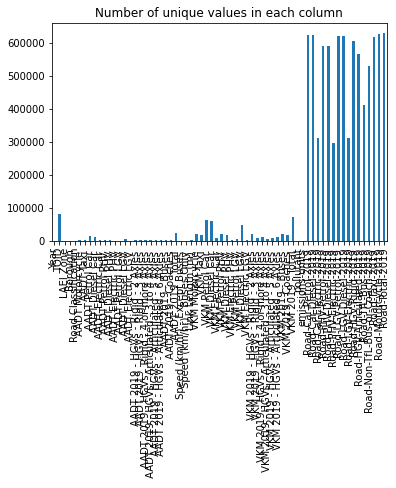

Year                                   1
TOID                               79437
LAEI Zone                              4
Borough                               34
Road Classification                   12
                                   ...  
Road-TfL-Bus-2019                 413673
Road-Non-TfL-Bus-or-Coach-2019    531430
Road-Taxi-2019                    620499
Road-Motorcycle-2019              627649
Road-Total-2019                   630096
Length: 66, dtype: int64


TOID
TOID
osgb4000000030418875    8
osgb4000000027947700    8
osgb4000000027908760    8
osgb4000000027987795    8
osgb4000000027869099    8
                       ..
osgb4000000030421503    1
osgb5000005128772013    1
osgb5000005132587507    1
osgb5000005126159288    1
osgb5000005126159285    1
Name: count, Length: 79437, dtype: int64
LAEI Zone
LAEI Zone
Outer London      322375
Inner London      187078
Non-GLA            98500
Central London     27200
Name: count, dtype: int64
Borough
Borough
Non-GLA                   99356
Barnet                    29648
Enfield                   25227
Hillingdon                24714
Westminster               24140
Croydon                   21793
Bromley                   21210
Hounslow                  20952
Ealing                    19937
Brent                     18577
Southwark                 18178
Redbridge                 17589
Havering                  17560
Bexley                    17090
Lambeth                   16977
Greenwich            

 AADT Petrol PHV 
 -       43377
89        2928
124       2896
28        2848
64        2712
         ...  
2487         8
1954         8
2076         8
1113         8
1704         8
Name: count, Length: 2246, dtype: int64
 AADT Diesel PHV 
 AADT Diesel PHV 
 -       43377
73        3992
69        3640
39        3608
86        3584
         ...  
1314         8
2019         8
1497         8
1000         8
1443         8
Name: count, Length: 1615, dtype: int64
 AADT Electric PHV 
 AADT Electric PHV 
1     137838
2     112560
3      79889
0      54716
4      52480
       ...  
62         8
70         8
72         8
65         8
59         8
Name: count, Length: 68, dtype: int64
 AADT Petrol LGV 
 AADT Petrol LGV 
3      29551
4      28810
6      27602
7      27224
5      26523
       ...  
131        8
119        8
126        8
149        8
136        8
Name: count, Length: 137, dtype: int64
 AADT Diesel LGV 
 AADT Diesel LGV 
 -       10921
329        744
767        736
519        656
6

 AADT 2019 - Coaches 
 -       103025
1          3760
28         3368
46         3352
17         3280
          ...  
1198          8
1217          8
1621          8
916           8
1206          8
Name: count, Length: 1253, dtype: int64
 AADT 2019 - Total 
 AADT 2019 - Total 
 -       5505
10905     536
3774      344
8278      328
1112      296
         ... 
8728        8
811         1
1495        1
2759        1
2596        1
Name: count, Length: 22870, dtype: int64
 Speed (km/hr) - Except Buses 
 Speed (km/hr) - Except Buses 
24       31647
23       30738
25       30510
22       28356
21       27084
         ...  
87          80
118         72
0           57
116         48
 -           1
Name: count, Length: 120, dtype: int64
 Speed (km/hr) - Buses Only 
 Speed (km/hr) - Buses Only 
 -       215851
22        31540
23        29026
21        28553
20        28362
24        26921
19        25120
18        23361
25        23155
26        22609
27        20048
17        19537
28        1

 VKM Diesel Car 
 -         10129
2792          64
2194          56
11975         56
16956         56
           ...  
85890          1
1091973        1
251658         1
2681261        1
4871           1
Name: count, Length: 59420, dtype: int64
 VKM Electric Car 
 VKM Electric Car 
 -       10129
83        1360
86        1296
59        1249
82        1232
         ...  
5311         8
5674         8
4512         8
9357         1
22975        1
Name: count, Length: 7160, dtype: int64
 VKM Petrol PHV 
 VKM Petrol PHV 
 -        43377
389         273
275         272
543         264
335         256
          ...  
9258          8
19624         8
15012         8
150248        1
57668         1
Name: count, Length: 20746, dtype: int64
 VKM Diesel PHV 
 VKM Diesel PHV 
 -        43377
312         384
240         329
203         328
320         320
          ...  
134850        8
13576         8
5947          8
47436         1
123589        1
Name: count, Length: 17544, dtype: int64
 VKM Elect

 VKM 2019 - HGVs - Rigid - 2 Axles 
 -        28115
14          792
26          697
24          688
49          681
          ...  
41660         8
5575          8
127940        1
33831         1
201159        1
Name: count, Length: 19386, dtype: int64
 VKM 2019 - HGVs - Rigid - 3 Axles 
 VKM 2019 - HGVs - Rigid - 3 Axles 
 -       45046
7         2232
6         2204
9         2144
26        2113
         ...  
20751        8
2597         8
3568         8
19012        1
29881        1
Name: count, Length: 7906, dtype: int64
 VKM 2019 - HGVs - Rigid - 4 or more Axles 
 VKM 2019 - HGVs - Rigid - 4 or more Axles 
 -       45263
6         2275
7         2208
9         2145
8         2091
         ...  
7806         8
18650        8
40932        1
10814        1
64337        1
Name: count, Length: 10758, dtype: int64
 VKM 2019 - HGVs - Articulated - 3 to 4 Axles 
 VKM 2019 - HGVs - Articulated - 3 to 4 Axles 
 -       97017
6         4900
7         4761
9         4562
8         4522
       

 VKM 2019 - Total 
 -         5505
16051        48
44298        40
109971       40
50350        40
           ... 
289757        1
3683878       1
902384        1
8934084       1
19650         1
Name: count, Length: 71678, dtype: int64
pollutant
pollutant
nox                 79388
pm10 exhaust        79388
pm10 brake wear     79388
pm10 tyre wear      79388
pm2.5 exhaust       79388
pm2.5 brake wear    79388
pm2.5 tyre wear     79388
co2                 79388
Name: count, dtype: int64
emissions-units
emissions-units
tonnes/year    635104
Name: count, dtype: int64


In [32]:
# Display the number of unique values in each column
emissions_df.nunique().plot(kind='bar')
pyplot.title('Number of unique values in each column')
pyplot.show()

# Display the number of unique values in each column
print(emissions_df.nunique())

# Display the unique values and their frequencies
for column in emissions_df.select_dtypes(include=['object']).columns:
    print(column)
    print(emissions_df[column].value_counts())

In [33]:
# Data cleaning

# replace all values that are ' -   ' with 0
clean_df = emissions_df.replace(' -  ', 0, regex=True)

# Remove leading / trailing spaces from column names
clean_df.columns = clean_df.columns.str.strip()

<ipython-input-33-9867b56ae80e>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_df = emissions_df.replace(' -  ', 0, regex=True)


# Feature Engineering

## Classify Columns into labels and targets

- Break into two sets of labels, speed and polution
- Create one set of targets relative to polution amount

In [34]:
# Create a set of column names
df_columns = clean_df.columns

# Labels
VKM_Label = []
AADT_Label = []

# Target
Target = []
for column_name in df_columns:
    if 'VKM' in column_name:
        VKM_Label = VKM_Label + [column_name]
    elif 'AADT' in column_name:
        AADT_Label = AADT_Label + [column_name]
    elif '2019' in column_name:
        Target = Target + [column_name]

print('VKM_Label:', VKM_Label)
print('AADT_Label:', AADT_Label)
print('Target:', Target)

VKM_Label: ['VKM Motorcycle', 'VKM Taxi', 'VKM Petrol Car', 'VKM Diesel Car', 'VKM Electric Car', 'VKM Petrol PHV', 'VKM Diesel PHV', 'VKM Electric PHV', 'VKM Petrol LGV', 'VKM Diesel LGV', 'VKM Electric LGV', 'VKM 2019 - HGVs - Rigid - 2 Axles', 'VKM 2019 - HGVs - Rigid - 3 Axles', 'VKM 2019 - HGVs - Rigid - 4 or more Axles', 'VKM 2019 - HGVs - Articulated - 3 to 4 Axles', 'VKM 2019 - HGVs - Articulated - 5 Axles', 'VKM 2019 - HGVs - Articulated - 6 Axles', 'VKM 2019 - Buses', 'VKM 2019 - Coaches', 'VKM 2019 - Total']
AADT_Label: ['AADT Motorcycle', 'AADT Taxi', 'AADT Petrol Car', 'AADT Diesel Car', 'AADT Electric Car', 'AADT Petrol PHV', 'AADT Diesel PHV', 'AADT Electric PHV', 'AADT Petrol LGV', 'AADT Diesel LGV', 'AADT Electric LGV', 'AADT 2019 - HGVs - Rigid - 2 Axles', 'AADT 2019 - HGVs - Rigid - 3 Axles', 'AADT 2019 - HGVs - Rigid - 4 or more Axles', 'AADT 2019 - HGVs - Articulated - 3 to 4 Axles', 'AADT 2019 - HGVs - Articulated - 5 Axles', 'AADT 2019 - HGVs - Articulated - 6 Ax

In [35]:
# Remove irrelevent labels
VKM_Label.remove('VKM 2019 - Total')
AADT_Label.remove('AADT 2019 - Total')
Target.remove('Road-Total-2019')

## Visualise the Data

- Check if there is any correlation between the labels and targets

https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/

In [36]:
# Folder to store the visuals
if not os.path.exists('charts'):
    os.makedirs('charts')

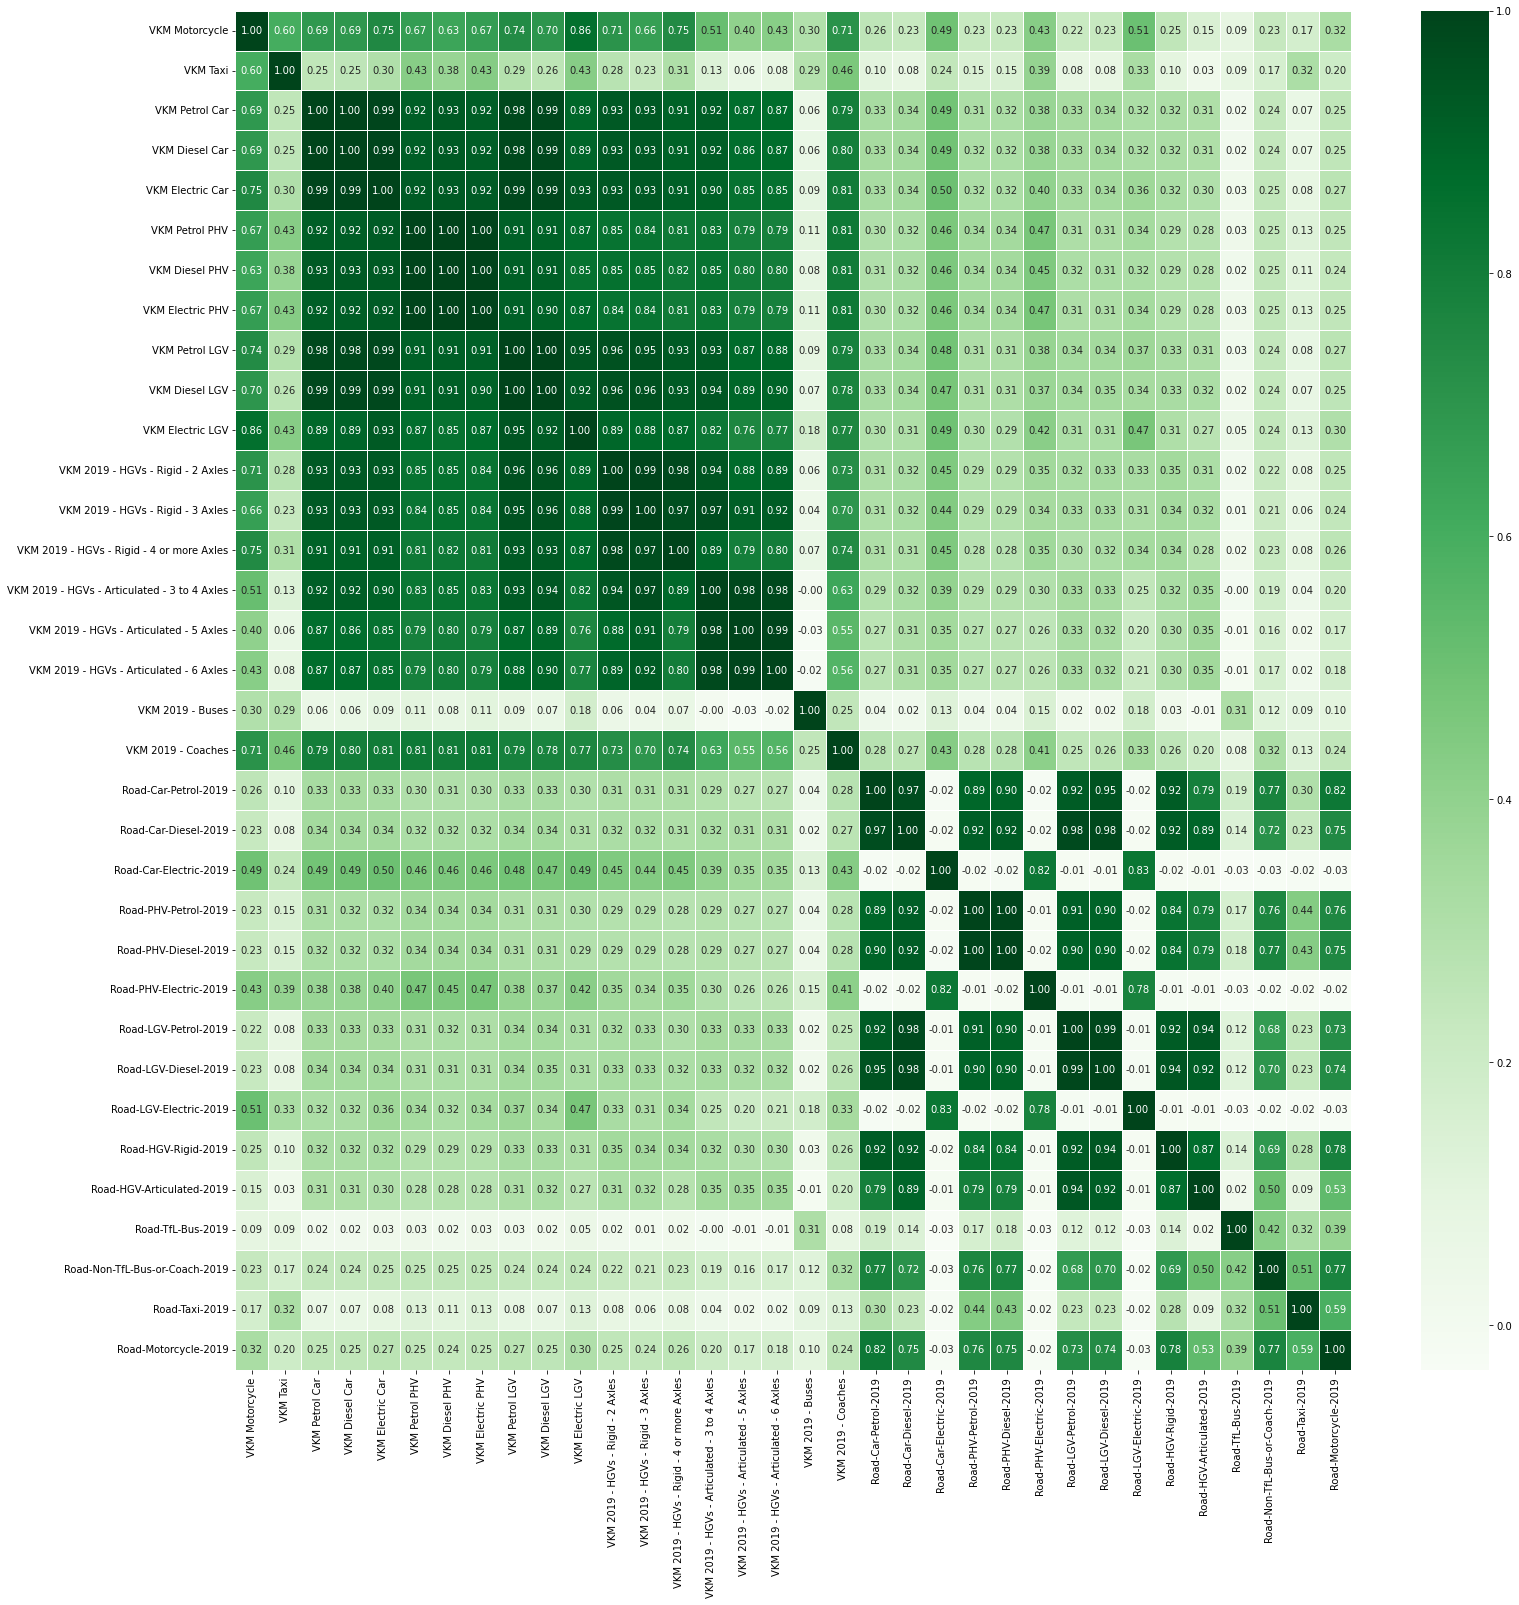

In [37]:
# plot the correlation matrix
VKM_correlation = clean_df[VKM_Label + Target].corr()
pyplot.figure(figsize=(25, 25))
seaborn.heatmap(VKM_correlation, annot=True, cmap='Greens', fmt=".2f", linewidth=.5)

# Save the plot
pyplot.savefig('charts/vkm_correlation_matrix.png')

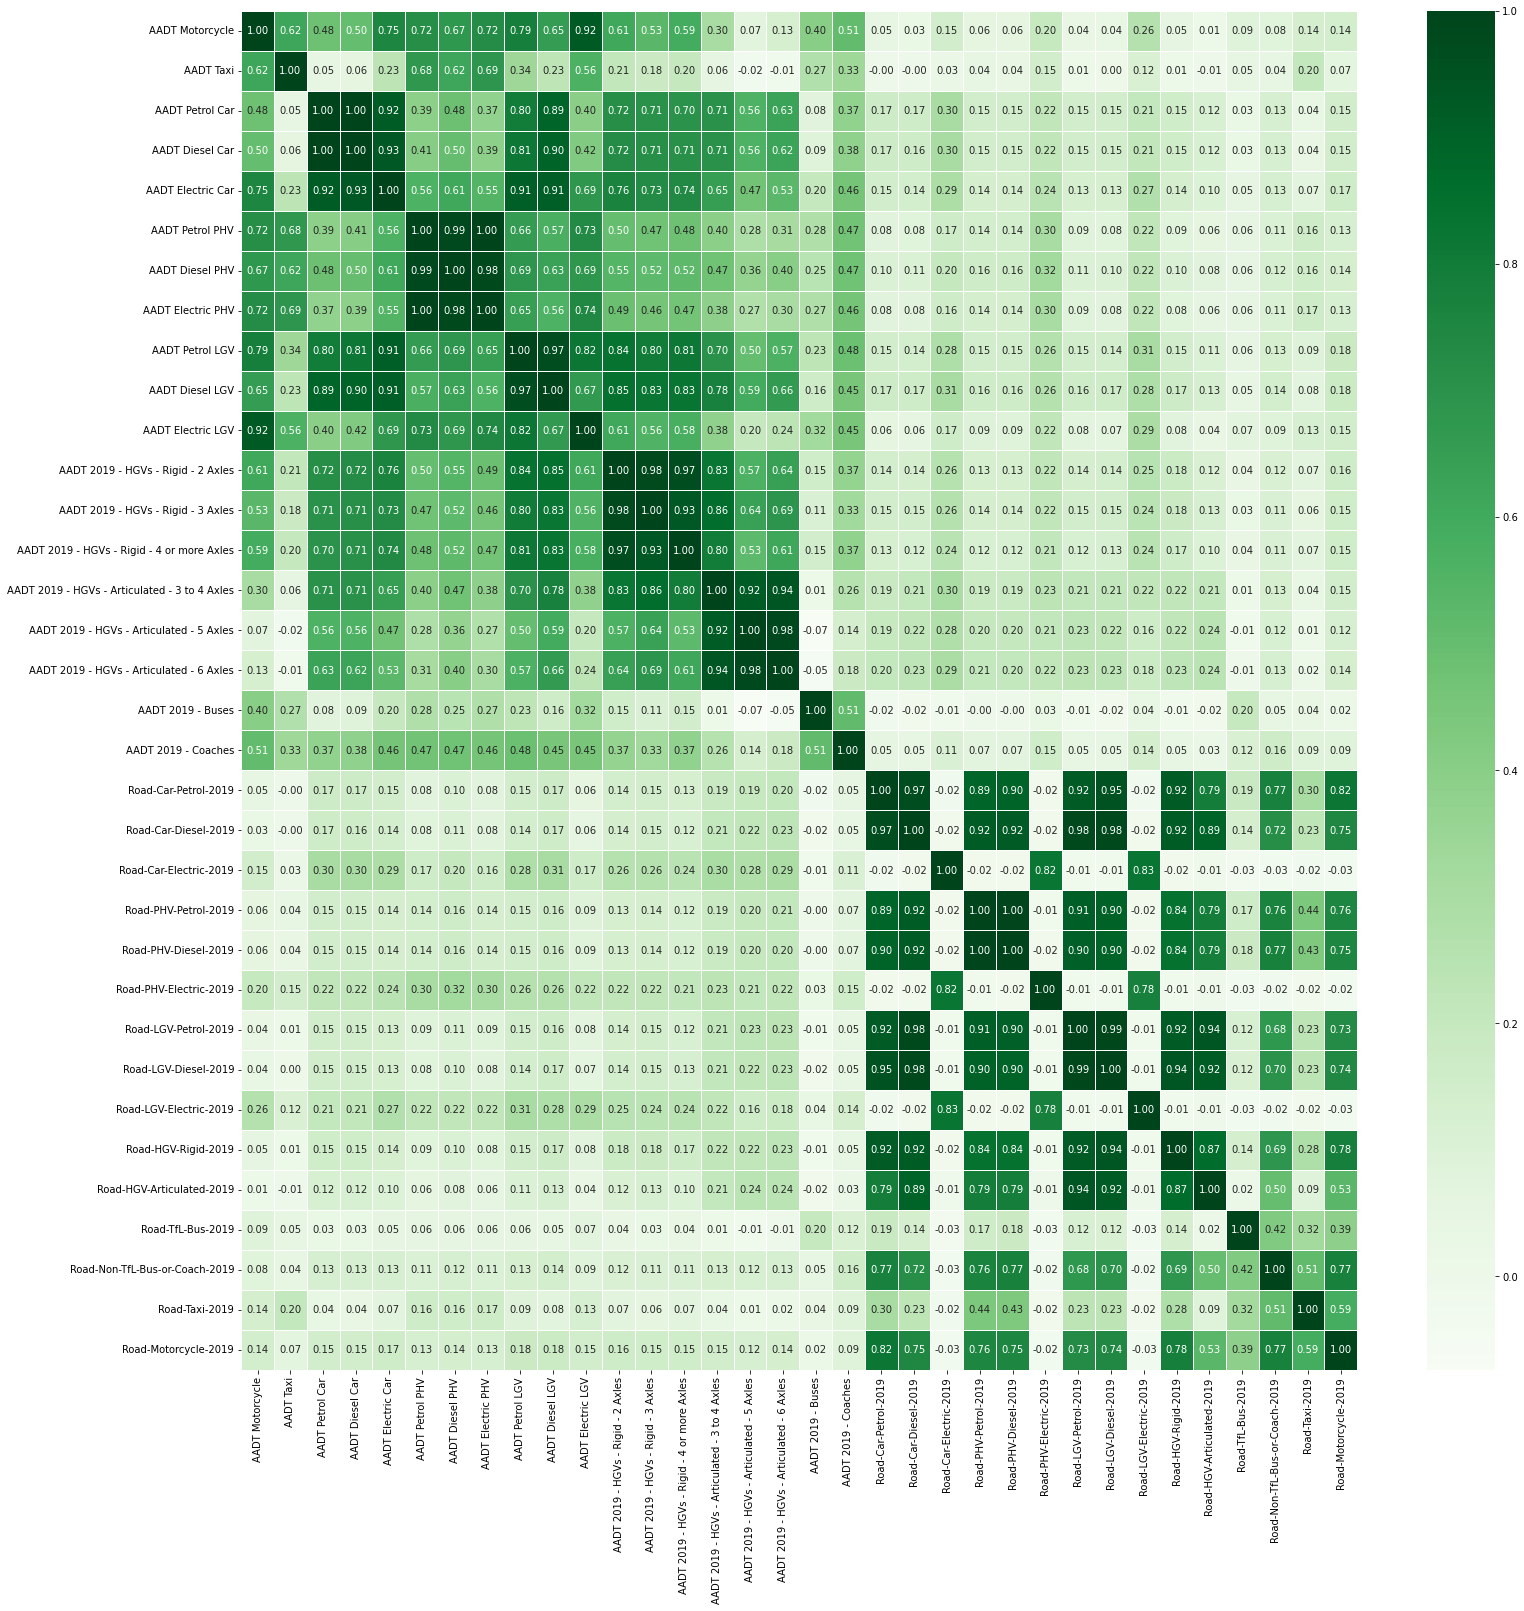

In [38]:
# plot the correlation matrix
AADT_correlation = clean_df[AADT_Label + Target].corr()
pyplot.figure(figsize=(25, 25))
seaborn.heatmap(AADT_correlation, annot=True, cmap='Greens', fmt=".2f", linewidth=.5)

# Save the plot
pyplot.savefig('charts/aadt_correlation_matrix.png')

## Calculate the Target

- Calculate the value we want to try and predict

In [39]:
# sum the target variables to one column
clean_df['Total Emissions'] = clean_df[Target].sum(axis=1)

## Split the data

- Split the data into the various pollutants

In [40]:
# Split pollutants_df by unique 'Pollutant' values into a dictionary
pollutants_df = {k: v for k, v in clean_df.groupby('pollutant')}

for k, v in pollutants_df.items():
    print(k, v.shape)

co2 (79388, 67)
nox (79388, 67)
pm10 brake wear (79388, 67)
pm10 exhaust (79388, 67)
pm10 tyre wear (79388, 67)
pm2.5 brake wear (79388, 67)
pm2.5 exhaust (79388, 67)
pm2.5 tyre wear (79388, 67)


## Split the data into test and train datasets

We have two feature sets, so lets see which one is better

In [41]:
vkm_train_test_set = {}

# VKM
for k, v in pollutants_df.items():
    x_train, x_test, y_train, y_test = train_test_split(v[VKM_Label], v['Total Emissions'], test_size=0.2, random_state=42)

    # drop indexes
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Add the data to the dictionary
    vkm_train_test_set[k] = {'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test}

vkm_train_test_set.keys()

dict_keys(['co2', 'nox', 'pm10 brake wear', 'pm10 exhaust', 'pm10 tyre wear', 'pm2.5 brake wear', 'pm2.5 exhaust', 'pm2.5 tyre wear'])

In [42]:
aadt_train_test_set = {}

# AADT
for k, v in pollutants_df.items():
    x_train, x_test, y_train, y_test = train_test_split(v[AADT_Label], v['Total Emissions'], test_size=0.2, random_state=42)

    # drop indexes
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Ass the data to the dictionary
    aadt_train_test_set[k] = {'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test}

aadt_train_test_set.keys()

dict_keys(['co2', 'nox', 'pm10 brake wear', 'pm10 exhaust', 'pm10 tyre wear', 'pm2.5 brake wear', 'pm2.5 exhaust', 'pm2.5 tyre wear'])

## Feature Selection

Lets see which feature set gives the best results using SelectKBest

https://medium.com/@Kavya2099/optimizing-performance-selectkbest-for-efficient-feature-selection-in-machine-learning-3b635905ed48

In [43]:
# VKM
for k, v in vkm_train_test_set.items():
    vkm_selector = SelectKBest(f_regression, k=10)
    vkm_selector.fit(v['x_train'], v['y_train'])
    v['x_train'] = vkm_selector.transform(v['x_train'])
    v['x_test'] = vkm_selector.transform(v['x_test']) 
    v['selected_features'] = [VKM_Label[i] for i in vkm_selector.get_support(indices=True)]
    v['x_train'] = pandas.DataFrame(v['x_train'], columns=v['selected_features'])
    v['x_test'] = pandas.DataFrame(v['x_test'], columns=v['selected_features'])
    v['selector'] = vkm_selector
    
    print(k, v['selected_features'])
    

co2 ['VKM Petrol Car', 'VKM Diesel Car', 'VKM Electric Car', 'VKM Petrol LGV', 'VKM Diesel LGV', 'VKM 2019 - HGVs - Rigid - 2 Axles', 'VKM 2019 - HGVs - Rigid - 3 Axles', 'VKM 2019 - HGVs - Articulated - 3 to 4 Axles', 'VKM 2019 - HGVs - Articulated - 5 Axles', 'VKM 2019 - HGVs - Articulated - 6 Axles']
nox ['VKM Petrol Car', 'VKM Diesel Car', 'VKM Electric Car', 'VKM Diesel PHV', 'VKM Petrol LGV', 'VKM Diesel LGV', 'VKM 2019 - HGVs - Rigid - 2 Axles', 'VKM 2019 - HGVs - Rigid - 3 Axles', 'VKM 2019 - HGVs - Rigid - 4 or more Axles', 'VKM 2019 - HGVs - Articulated - 3 to 4 Axles']
pm10 brake wear ['VKM Motorcycle', 'VKM Petrol Car', 'VKM Diesel Car', 'VKM Electric Car', 'VKM Petrol LGV', 'VKM Diesel LGV', 'VKM Electric LGV', 'VKM 2019 - HGVs - Rigid - 2 Axles', 'VKM 2019 - HGVs - Rigid - 4 or more Axles', 'VKM 2019 - Coaches']
pm10 exhaust ['VKM Petrol Car', 'VKM Diesel Car', 'VKM Electric Car', 'VKM Diesel PHV', 'VKM Petrol LGV', 'VKM Diesel LGV', 'VKM 2019 - HGVs - Rigid - 2 Axles', '

In [44]:
# AADT
for k, v in aadt_train_test_set.items():
    aadt_selector = SelectKBest(f_regression, k=10)
    aadt_selector.fit(v['x_train'], v['y_train'])
    v['x_train'] = aadt_selector.transform(v['x_train'])
    v['x_test'] = aadt_selector.transform(v['x_test']) 
    v['selected_features'] = [AADT_Label[i] for i in aadt_selector.get_support(indices=True)]
    v['x_train'] = pandas.DataFrame(v['x_train'], columns=v['selected_features'])
    v['x_test'] = pandas.DataFrame(v['x_test'], columns=v['selected_features'])
    v['selector'] = aadt_selector
    
    print(k, v['selected_features'])

#Interesting, the features are the same - clearly a direct coorolation between distance travlled and polution created

co2 ['AADT Petrol Car', 'AADT Diesel Car', 'AADT Electric Car', 'AADT Petrol LGV', 'AADT Diesel LGV', 'AADT 2019 - HGVs - Rigid - 2 Axles', 'AADT 2019 - HGVs - Rigid - 3 Axles', 'AADT 2019 - HGVs - Articulated - 3 to 4 Axles', 'AADT 2019 - HGVs - Articulated - 5 Axles', 'AADT 2019 - HGVs - Articulated - 6 Axles']
nox ['AADT Petrol Car', 'AADT Diesel Car', 'AADT Electric Car', 'AADT Petrol LGV', 'AADT Diesel LGV', 'AADT 2019 - HGVs - Rigid - 2 Axles', 'AADT 2019 - HGVs - Rigid - 3 Axles', 'AADT 2019 - HGVs - Articulated - 3 to 4 Axles', 'AADT 2019 - HGVs - Articulated - 5 Axles', 'AADT 2019 - HGVs - Articulated - 6 Axles']
pm10 brake wear ['AADT Petrol Car', 'AADT Diesel Car', 'AADT Electric Car', 'AADT Petrol LGV', 'AADT Diesel LGV', 'AADT 2019 - HGVs - Rigid - 2 Axles', 'AADT 2019 - HGVs - Rigid - 3 Axles', 'AADT 2019 - HGVs - Rigid - 4 or more Axles', 'AADT 2019 - HGVs - Articulated - 3 to 4 Axles', 'AADT 2019 - HGVs - Articulated - 6 Axles']
pm10 exhaust ['AADT Petrol Car', 'AADT Di

In [45]:
# create a table using dataframe for the selected features

selected_features_df = pandas.DataFrame(columns=['Pollutant', 'Feature', 'K-Score', 'P-value'])
# VKM
for k, v in vkm_train_test_set.items():
    for i in range(len(v['selected_features'])):
        # using concat to append a row to the dataframe
        selected_features_df = pandas.concat([selected_features_df,
                                              pandas.DataFrame([[k, v['selected_features'][i],
                                                                v['selector'].scores_[i],
                                                                v['selector'].pvalues_[i]]],
                                                                columns=['Pollutant', 'Feature', 'K-Score', 'P-value'])],
                                             ignore_index=True)

# AADT
for k, v in aadt_train_test_set.items():
    for i in range(len(v['selected_features'])):
        # using concat to append a row to the dataframe
        selected_features_df = pandas.concat([selected_features_df,
                                              pandas.DataFrame([[k, v['selected_features'][i],
                                                                v['selector'].scores_[i],
                                                                v['selector'].pvalues_[i]]],
                                                                columns=['Pollutant', 'Feature', 'K-Score', 'P-value'])],
                                             ignore_index=True)

# Order the dataframe by pollutant and score
selected_features_df = selected_features_df.sort_values(by=['Pollutant', 'K-Score'], ascending=False)
selected_features_df.head()

<ipython-input-45-70eee0aff4f8>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_features_df = pandas.concat([selected_features_df,


Pollutant                                       Feature  \
79  pm2.5 tyre wear  VKM 2019 - HGVs - Articulated - 3 to 4 Axles   
73  pm2.5 tyre wear                                VKM Diesel PHV   
72  pm2.5 tyre wear                              VKM Electric Car   
74  pm2.5 tyre wear                                VKM Petrol LGV   
78  pm2.5 tyre wear     VKM 2019 - HGVs - Rigid - 4 or more Axles   

           Score  P-value  
79  2.507873e+06      0.0  
73  2.411932e+06      0.0  
72  2.357863e+06      0.0  
74  2.015125e+06      0.0  
78  1.988014e+06      0.0

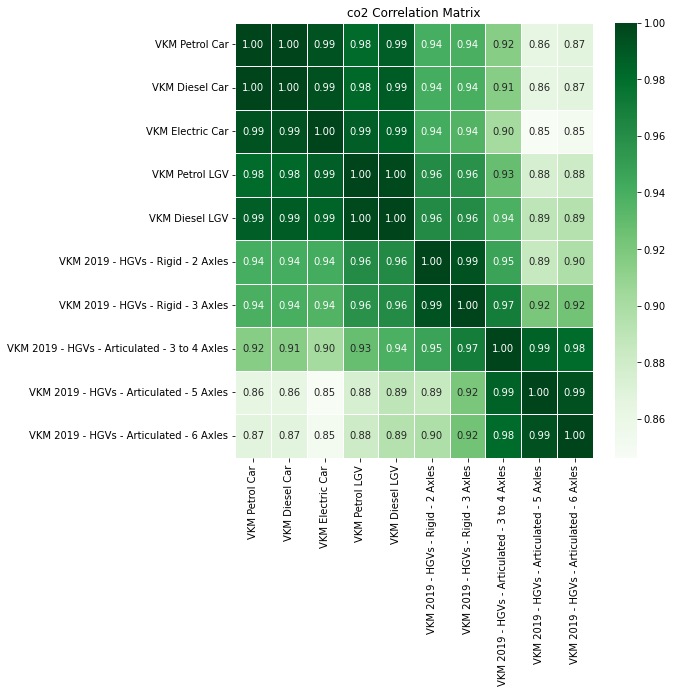

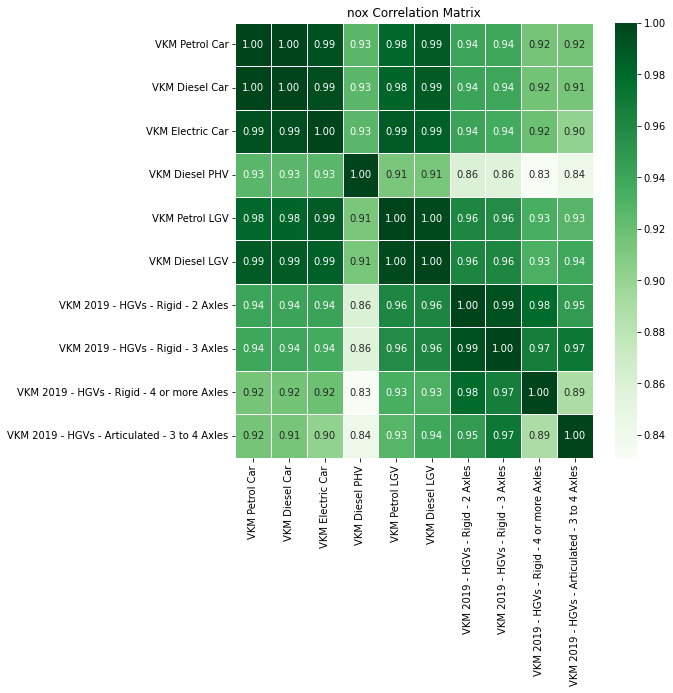

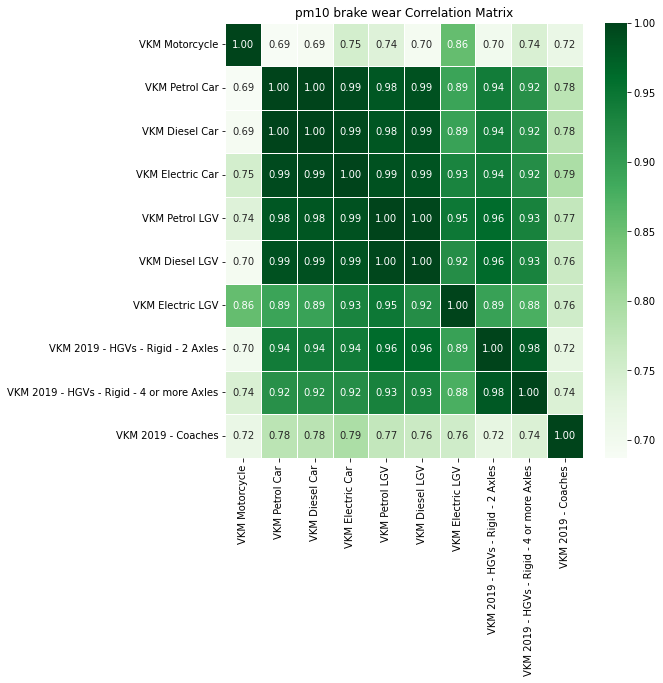

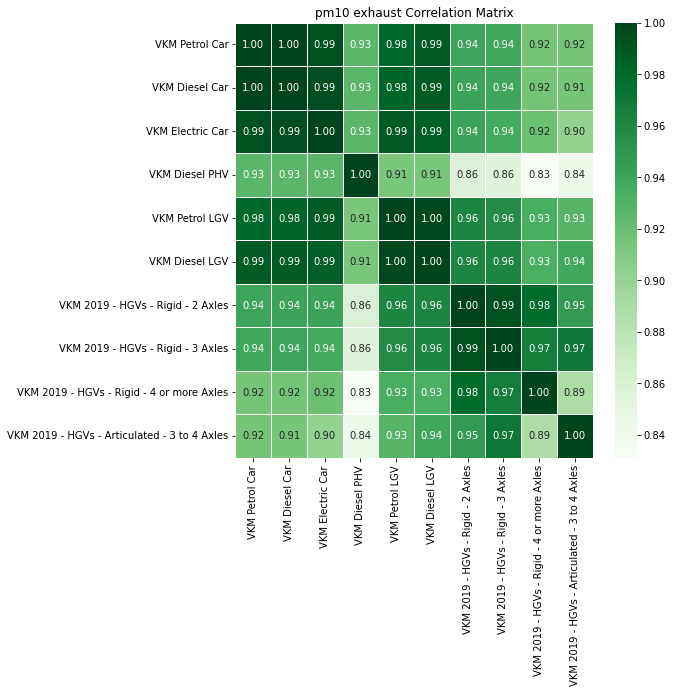

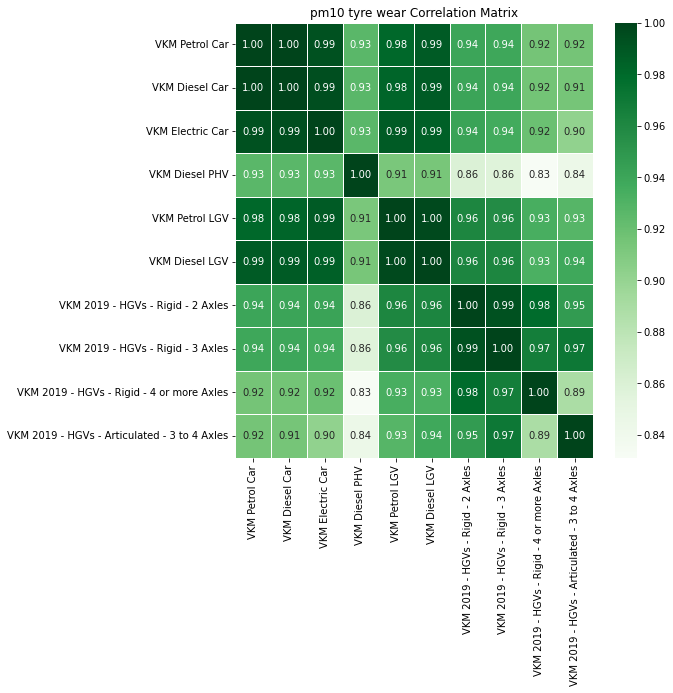

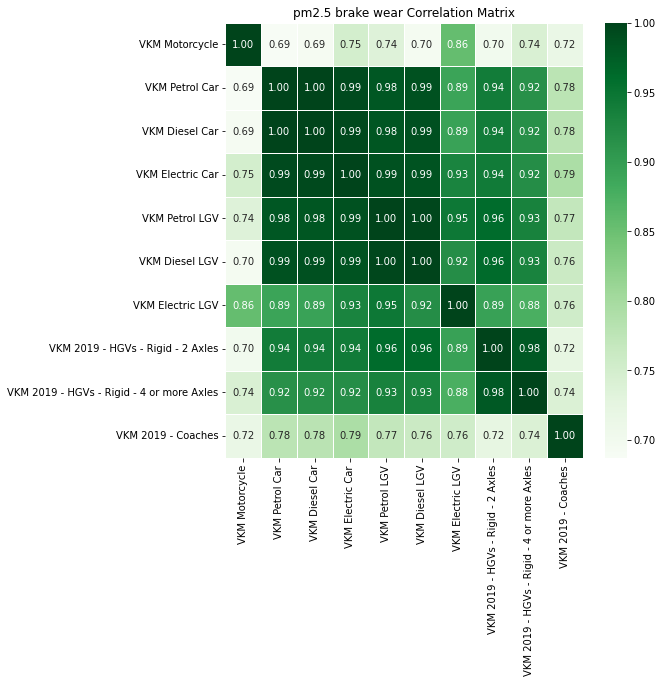

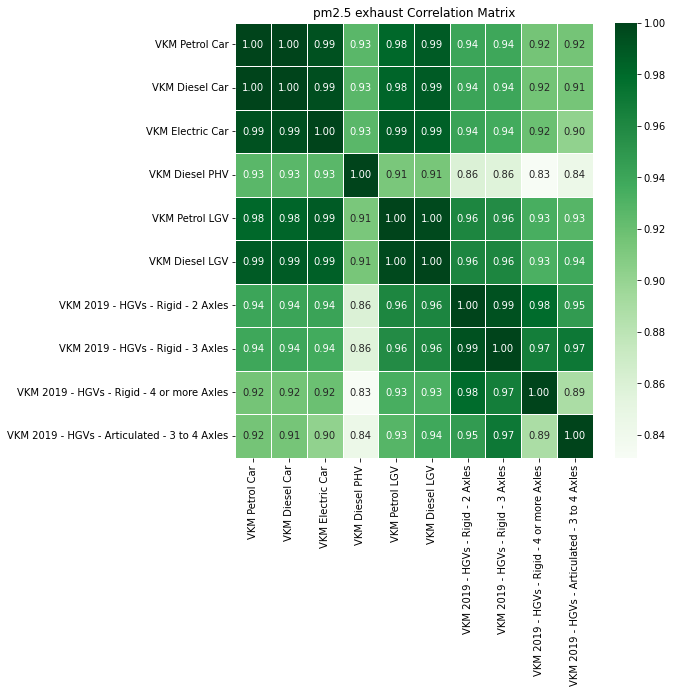

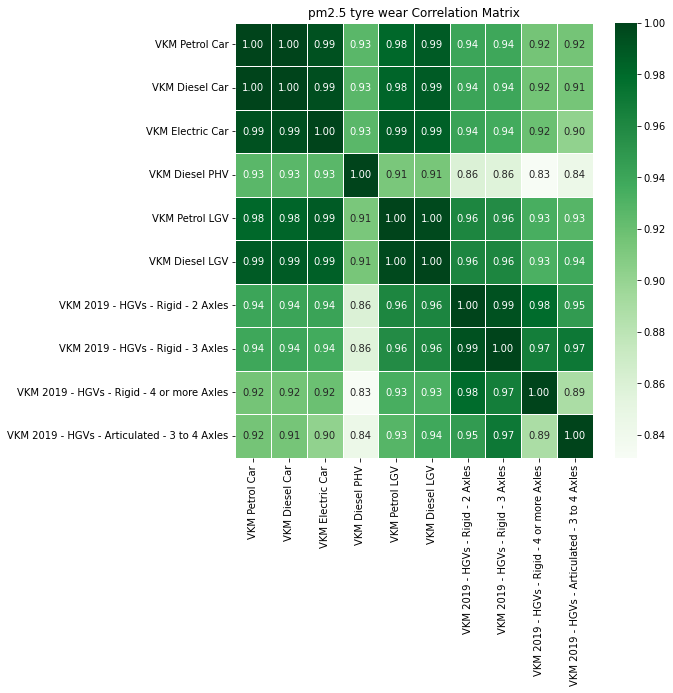

In [46]:
# visualize correlation matrix of selected features
# VKM
for k, v in vkm_train_test_set.items():
    corr = pandas.DataFrame(v['x_train'], columns=v['selected_features']).corr()
    pyplot.figure(figsize=(8,8))
    pyplot.title(k + ' Correlation Matrix')
    seaborn.heatmap(corr, annot=True, fmt='.2f', cmap='Greens', linewidths=0.5)

    # Save the plot
    pyplot.savefig('charts/' + k + '_vkm_correlation_matrix.png')

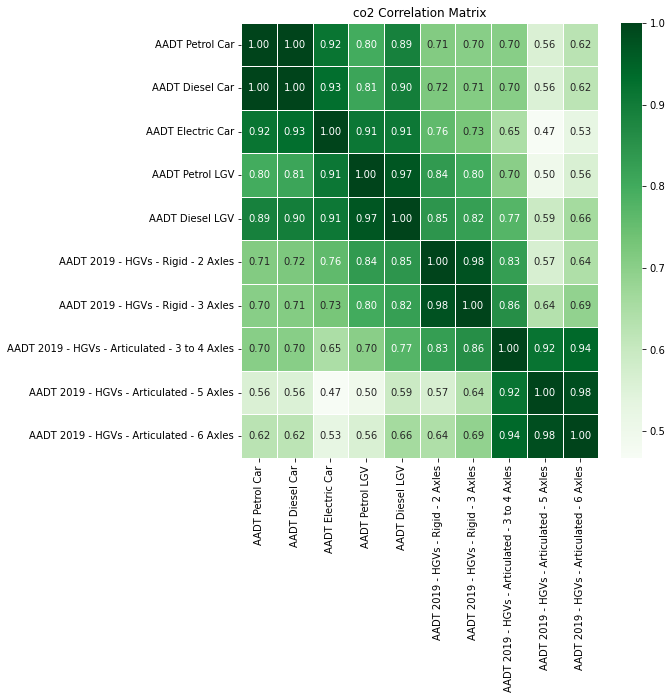

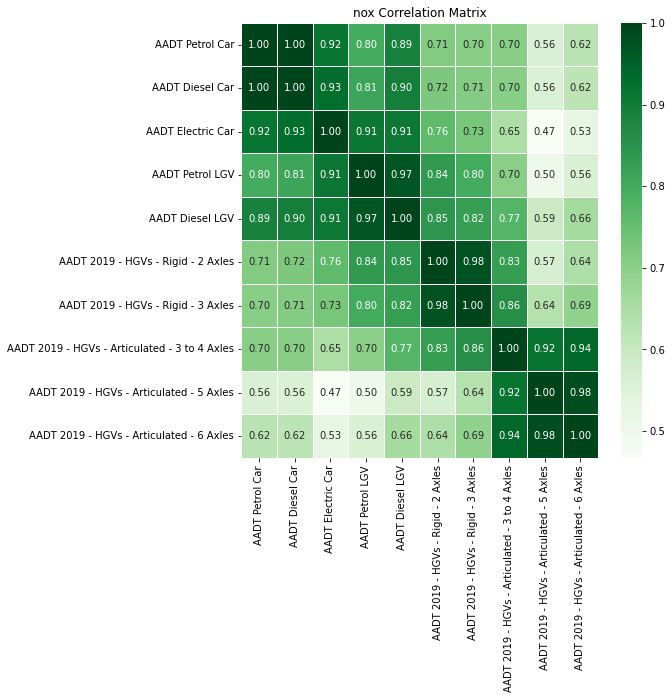

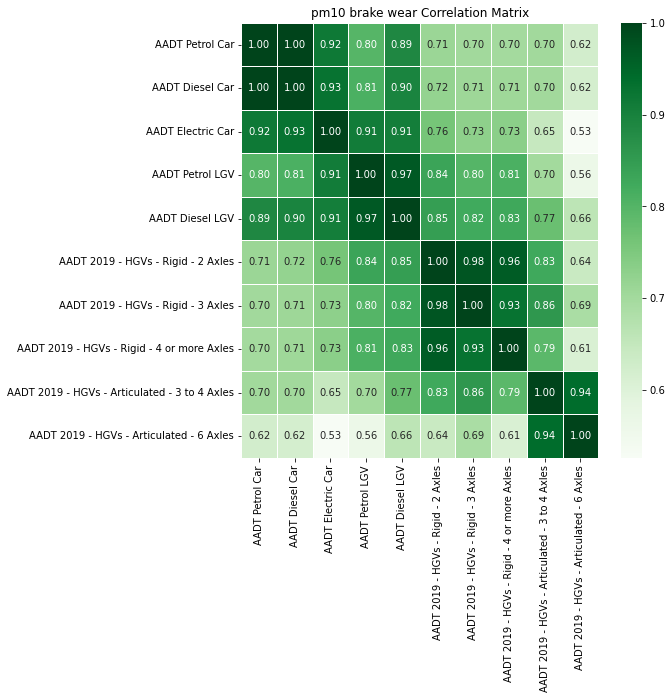

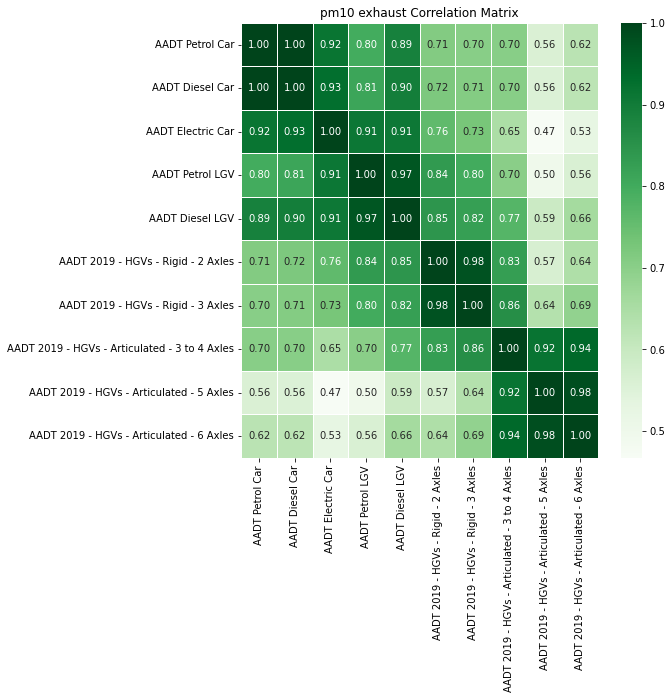

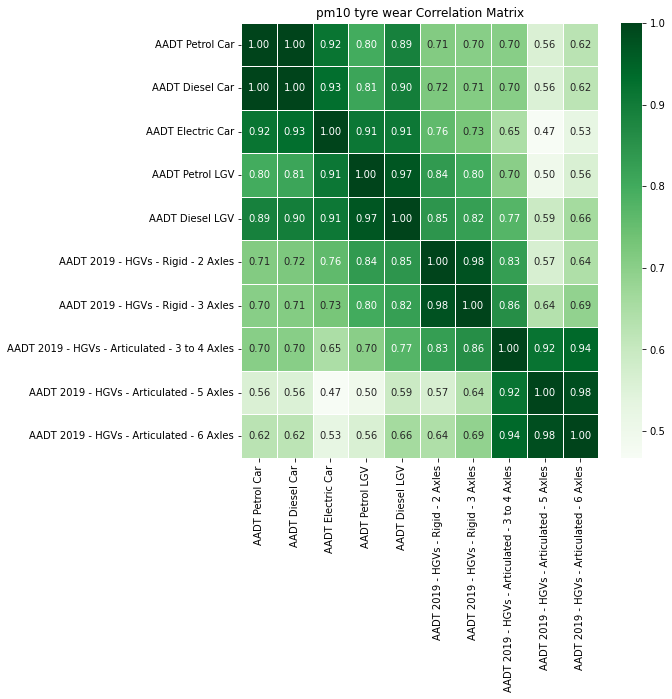

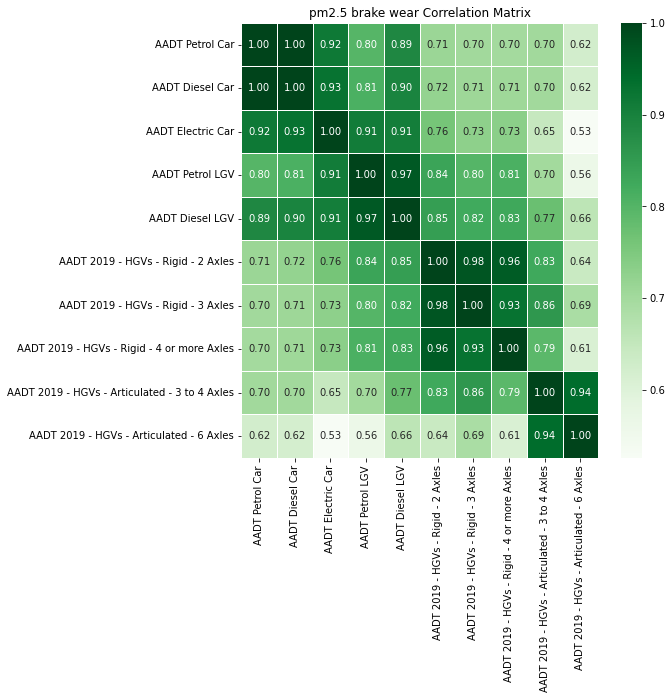

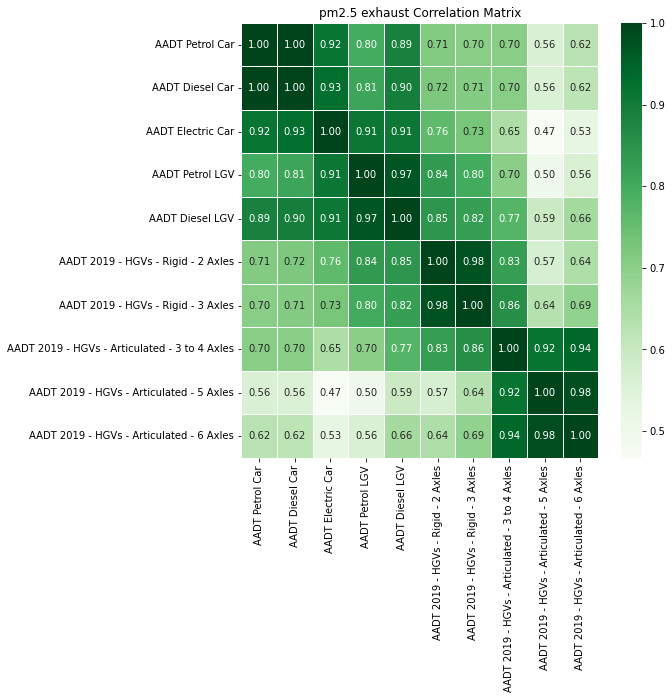

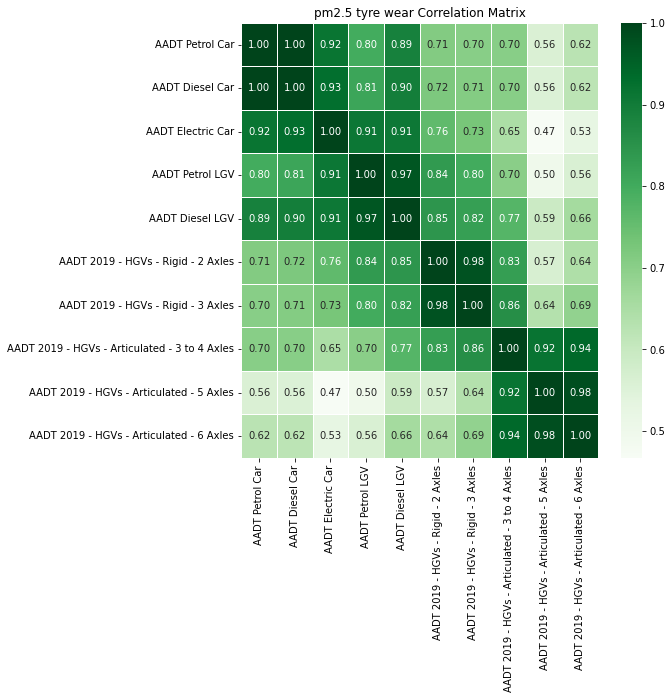

In [47]:
# visualize correlation matrix of selected features
# AADT
for k, v in aadt_train_test_set.items():
    corr = pandas.DataFrame(v['x_train'], columns=v['selected_features']).corr()
    pyplot.figure(figsize=(8,8))
    pyplot.title(k + ' Correlation Matrix')
    seaborn.heatmap(corr, annot=True, fmt='.2f', cmap='Greens', linewidths=0.5)

    # Save the plot
    pyplot.savefig('charts/' + k + '_aadt_correlation_matrix.png')

# Model Development

## Standardise the Data

VKM gives us the best features, so lets use that

[https://scikit-learn.org/stable/modules/preprocessing.html](https:\scikit-learn.org\stable\modules\preprocessing.html)

In [48]:
train_test_set = vkm_train_test_set

# stardaize the x_train and x_test
for k, v in train_test_set.items():
    # initialize the scaler
    scaler = StandardScaler()

    # fit the scaler to the x_train
    scaler.fit(v['x_train'])

    # transform the x_train and x_test
    v['x_train'] = scaler.transform(v['x_train'])
    v['x_test'] = scaler.transform(v['x_test'])
    v['x_train'] = pandas.DataFrame(v['x_train'], columns=v['selected_features'])
    v['x_test'] = pandas.DataFrame(v['x_test'], columns=v['selected_features'])
    
    # save the scaler
    v['scaler'] = scaler


## Model Training

- Define a function to handle model training, makes life easier
- Define a function to hanlde hyperparamter tuning

In [49]:
# Lets keep the results of the experiments here
experimentresults_set = []

In [50]:
def train_eval_model(experiment, pollutant, model, x_train, y_train, x_test, y_test):
    # Ensure we use the initialised datafram
    global experimentresults_df

    # train the model
    model.fit(x_train, y_train)
    
    # predict the y_test
    y_pred = model.predict(x_test)
    
    # evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = numpy.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the result in a dictionary
    Experiment_Results = {'experiment': experiment,
                          'model': model,
                          'pollutant': pollutant,
                          'mean_squared_error': mse,
                          'root_mean_squared_error': rmse,
                          'r2_score': r2}
    
    # Add the results to the results set
    experimentresults_set.append(Experiment_Results)

    # Return the model and the evaluation metrics
    return Experiment_Results

In [51]:
def hyperparameter_tuning(experiment, pollutant, model, param_grid, x_train, y_train, x_test, y_test):
    # Ensure we use the initialised datafram
    global experimentresults_df

    # initialize the grid search
    grid_search = GridSearchCV(model, param_grid)

    # fit the grid search to the training data
    grid_search.fit(x_train, y_train)

    # predict the y_test
    y_pred = grid_search.best_estimator_.predict(x_test)
    
    # evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = numpy.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the result in a dictionary
    Experiment_Results= {'experiment': experiment,
                         'model': model,
                         'pollutant': pollutant,
                         'best_model': str(grid_search.best_estimator_),
                         'best_mean_squared_error': mse,
                         'best_root_mean_squared_error': rmse,
                         'best_r2_score': r2,
                         'best_params': grid_search.best_params_,
                         'best_score': grid_search.best_score_}
    
    # Add the results to the results set
    experimentresults_set.append(Experiment_Results)

    # Return the model and the evaluation metrics
    return Experiment_Results

**Linear Regression**

- Linear regression

In [52]:
# Set the experiment name
experimentname = "LinearRegression"

# Store the experement results
LinearRegression_Result = {}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    LinearRegression_Result[k] = train_eval_model(experimentname,
                                                  k,
                                                  LinearRegression(),
                                                  v['x_train'],
                                                  v['y_train'],
                                                  v['x_test'],
                                                  v['y_test'])

    print(LinearRegression_Result[k]['pollutant'], LinearRegression_Result[k]['mean_squared_error'], LinearRegression_Result[k]['root_mean_squared_error'], LinearRegression_Result[k]['r2_score'])

co2 2080.7667527433787 45.61542231245238 0.9927323899777769
nox 0.01578452771520847 0.1256364903808144 0.986641578016163
pm10 brake wear 0.000695594148845827 0.026374118920749312 0.7231417549587499
pm10 exhaust 2.6147098929986904e-06 0.0016170064604072213 0.9855589015669712


pm10 tyre wear 7.0455001285080726e-06 0.0026543360993868267 0.987162904506653
pm2.5 brake wear 0.00011016229700067735 0.010495822835808412 0.723141754958749
pm2.5 exhaust 2.359775678431194e-06 0.0015361561373868197 0.985558901566972
pm2.5 tyre wear 3.452295062968956e-06 0.0018580352695707787 0.987162904506653


**Support Vector Regression**

Battles to converge, even with 10000 iterations

In [53]:
# Set the experiment name
experimentname = "SupportVectorRegression"

# model dict for each pollutant
SupportVectorRegression_Result = {}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    SupportVectorRegression_Result[k] = train_eval_model(experimentname,
                                                         k,
                                                         LinearSVR(random_state=42, max_iter=10000),
                                                         v['x_train'],
                                                         v['y_train'],
                                                         v['x_test'],
                                                         v['y_test'])
    print(SupportVectorRegression_Result[k]['pollutant'], SupportVectorRegression_Result[k]['mean_squared_error'], SupportVectorRegression_Result[k]['root_mean_squared_error'], SupportVectorRegression_Result[k]['r2_score'])

co2 2543.5795760294777 50.433912955762985 0.9911158978320365


C:\Users\dillo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


nox 0.01966538550741836 0.14023332523839818 0.9833572139234921


C:\Users\dillo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


pm10 brake wear 0.0007889519210476403 0.028088287969323448 0.6859837814254164


C:\Users\dillo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


pm10 exhaust 5.103888836151884e-06 0.00225917879685338 0.9718111132437809


C:\Users\dillo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


pm10 tyre wear 1.2924071886617487e-05 0.0035950065210813577 0.9764519846788334


C:\Users\dillo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


pm2.5 brake wear 0.00014424988956663378 0.012010407552062244 0.6374733247204628


C:\Users\dillo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


pm2.5 exhaust 4.630395337549906e-06 0.002151835341644408 0.9716634104399929


pm2.5 tyre wear 6.659624484637771e-06 0.002580624824463597 0.9752366950391531


C:\Users\dillo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**Random Forest Regression**

- RandomForest
- RandomForest with hyperparamter tuning

In [ ]:
# Set the experiment name
experimentname = "RandomForestRegressor"

# model dict for each pollutant
RandomForest_Results = {}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    RandomForest_Results[k] = train_eval_model(experimentname,
                                               k,
                                               RandomForestRegressor(random_state=42),
                                               v['x_train'],
                                               v['y_train'],
                                               v['x_test'],
                                               v['y_test'])
    
    print(RandomForest_Results[k]['pollutant'], RandomForest_Results[k]['mean_squared_error'], RandomForest_Results[k]['root_mean_squared_error'], RandomForest_Results[k]['r2_score'])

In [28]:
# Set the experiment name
experimentname = "RandomForestRegressor_Hyperparameter_Tuning"

# model dict for each pollutant
RandomForest_Hyperparameter_Results = {}

# Set the hyperparameters for the model
param_grid = {'n_estimators': [100, 150, 200]}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    RandomForest_Hyperparameter_Results[k] = hyperparameter_tuning(experimentname,
                                                                   k,
                                                                   RandomForestRegressor(random_state=42),
                                                                   param_grid,
                                                                   v['x_train'],
                                                                   v['y_train'],
                                                                   v['x_test'],
                                                                   v['y_test'])
    
    print(RandomForest_Hyperparameter_Results[k]['pollutant'], RandomForest_Hyperparameter_Results[k]['best_mean_squared_error'], RandomForest_Hyperparameter_Results[k]['best_root_mean_squared_error'], RandomForest_Hyperparameter_Results[k]['best_r2_score'], RandomForest_Hyperparameter_Results[k]['best_params'], RandomForest_Hyperparameter_Results[k]['best_score'])

co2 141543.5638257269 376.2227582506498 0.5056229047850924 {'n_estimators': 200} 0.4592448522833731


nox 0.6080613021729219 0.7797828557828915 0.4853986376392516 {'n_estimators': 200} 0.435343926345387


pm10 brake wear 0.0017176249761050783 0.04144423935971172 0.3163561865600589 {'n_estimators': 150} 0.2333642070366345


pm10 exhaust 9.763121323173704e-05 0.009880850835415796 0.4607807297510246 {'n_estimators': 200} 0.413282854169699


pm10 tyre wear 0.0002754286668583704 0.016596043711028553 0.49816137483843137 {'n_estimators': 200} 0.44518726902651623


pm2.5 brake wear 0.00027189213757973437 0.016489152118278682 0.3166847269862503 {'n_estimators': 150} 0.23230440952292483


pm2.5 exhaust 8.826176360086082e-05 0.009394773206462242 0.45986526275241435 {'n_estimators': 200} 0.41236022871731903


pm2.5 tyre wear 0.00013506598333790933 0.011621789162513203 0.49776745776751674 {'n_estimators': 200} 0.4449506077537757


**Gradient Boosting Regression**

- Gradient boosting
- Gradient boosting with hyperparameter tuning (**<u>This may take a few hours to run</u>**)

In [29]:
# Set the experiment name
experimentname = 'GradientBoostingRegressor'

# model dict for each pollutant
GradientBoost_Results = {}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    GradientBoost_Results[k] = train_eval_model(experimentname,
                                                k,
                                                GradientBoostingRegressor(random_state=42),
                                                v['x_train'],
                                                v['y_train'],
                                                v['x_test'],
                                                v['y_test'])

    print(GradientBoost_Results[k]['pollutant'], GradientBoost_Results[k]['mean_squared_error'], GradientBoost_Results[k]['root_mean_squared_error'], GradientBoost_Results[k]['r2_score'])

co2 140085.06045740884 374.27938823479025 0.5107171007986816


nox 0.5997889299935679 0.7744604121538866 0.4923995337302186


pm10 brake wear 0.0017113598770954269 0.04136858563083136 0.3188498020105336


pm10 exhaust 9.638166759878361e-05 0.009817416544019287 0.4676819968974715


pm10 tyre wear 0.00026899618154030956 0.016401103058645464 0.5098815404450404


pm2.5 brake wear 0.0002713907961476738 0.016473942944774146 0.31794469081076904


pm2.5 exhaust 8.695480593410074e-05 0.009324956082153993 0.46786344007324787


pm2.5 tyre wear 0.00013180619233530433 0.01148068779887792 0.5098887416165299


In [30]:
# Set the experiment name
experimentname = 'GradientBoostingRegressor_Hyperparameter_Tuning'

# model dict for each pollutant
GradientBoost_Hyperparameter_Results = {}

# Set the hyperparameters for the model
param_grid = {'n_estimators': [100, 150, 200],
              'max_depth': [2, 4, 6]}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    GradientBoost_Hyperparameter_Results[k] = hyperparameter_tuning(experimentname, 
                                                                    k,
                                                                    GradientBoostingRegressor(random_state=42),
                                                                    param_grid,
                                                                    x_train=v['x_train'],
                                                                    y_train=v['y_train'],
                                                                    x_test=v['x_test'],
                                                                    y_test=v['y_test'])
    
    print(GradientBoost_Hyperparameter_Results[k]['pollutant'], GradientBoost_Hyperparameter_Results[k]['best_mean_squared_error'], GradientBoost_Hyperparameter_Results[k]['best_root_mean_squared_error'], GradientBoost_Hyperparameter_Results[k]['best_r2_score'], GradientBoost_Hyperparameter_Results[k]['best_params'], GradientBoost_Hyperparameter_Results[k]['best_score'])

co2 137709.67466999288 371.09254192181345 0.5190137431457922 {'max_depth': 2, 'n_estimators': 100} 0.506912413304024


nox 0.5999111621322719 0.774539322521634 0.49229608885570253 {'max_depth': 2, 'n_estimators': 100} 0.4877528157278156


pm10 brake wear 0.0016937935064581114 0.04115572264531521 0.3258415148569699 {'max_depth': 2, 'n_estimators': 100} 0.3125014553117834


pm10 exhaust 9.612860357533789e-05 0.009804519548419386 0.46907967488929136 {'max_depth': 2, 'n_estimators': 100} 0.46461574190016197


pm10 tyre wear 0.0002680958335760473 0.01637363226581223 0.5115219992604066 {'max_depth': 2, 'n_estimators': 100} 0.49846874209618974


pm2.5 brake wear 0.0002683070180482261 0.016380079915807068 0.32569479602784246 {'max_depth': 2, 'n_estimators': 100} 0.31252568328277974


pm2.5 exhaust 8.675172566352792e-05 0.009314060643109853 0.469106228616224 {'max_depth': 2, 'n_estimators': 100} 0.4646308002048033


pm2.5 tyre wear 0.0001313898412768168 0.011462540786266228 0.511436911225174 {'max_depth': 2, 'n_estimators': 100} 0.4984551302143242


**XGBoost Regression**

- XGBoost
- XGBoost with hyperparamter tuning

So much faster than Gradient Boosting!!!!

In [31]:
# Set the experiment name
experimentname = 'XGBoost'

# model dict for each pollutant
XGBoost_Results = {}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    XGBoost_Results[k] = train_eval_model(experimentname,
                                          k,
                                          XGBRegressor(random_state=42),
                                          v['x_train'],
                                          v['y_train'],
                                          v['x_test'],
                                          v['y_test'])

    print(XGBoost_Results[k]['pollutant'], XGBoost_Results[k]['mean_squared_error'], XGBoost_Results[k]['root_mean_squared_error'], XGBoost_Results[k]['r2_score'])

co2 140852.45767557592 375.30315436401 0.5080367697589704


nox 0.6162515016722173 0.7850168798645143 0.47846728416340556


pm10 brake wear 0.0017129755996188865 0.04138810939894315 0.318206717098073


pm10 exhaust 9.961073855992728e-05 0.009980517950483696 0.44984776919902847


pm10 tyre wear 0.00027640478312051283 0.016625425802682853 0.4963828640952367


pm2.5 brake wear 0.00027106412188013837 0.016464025081374796 0.31876568371734804


pm2.5 exhaust 9.002816379805386e-05 0.009488317226887697 0.44905543902512546


pm2.5 tyre wear 0.00013459382320848737 0.01160145780531427 0.49952314914353957


In [32]:
# Set the experiment name
experimentname = 'XGBoost_Hyperparameter_Tuning'

# model dict for each pollutant
XGBoost_Hyperparameter_Results = {}

# Set the hyperparameters for the model
param_grid = {'n_estimators': [100, 150, 200],
                'max_depth': [6, 8]}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    XGBoost_Hyperparameter_Results[k] = hyperparameter_tuning(experimentname,
                                                              k,
                                                              XGBRegressor(random_state=42),
                                                              param_grid,
                                                              x_train=v['x_train'],
                                                              y_train=v['y_train'],
                                                              x_test=v['x_test'],
                                                              y_test=v['y_test'])
                                               
    print(XGBoost_Hyperparameter_Results[k]['pollutant'], XGBoost_Hyperparameter_Results[k]['best_mean_squared_error'], XGBoost_Hyperparameter_Results[k]['best_root_mean_squared_error'], XGBoost_Hyperparameter_Results[k]['best_r2_score'], XGBoost_Hyperparameter_Results[k]['best_params'], XGBoost_Hyperparameter_Results[k]['best_score'])

co2 140852.45767557592 375.30315436401 0.5080367697589704 {'max_depth': 6, 'n_estimators': 100} 0.3969372404733217


nox 0.6162515016722173 0.7850168798645143 0.47846728416340556 {'max_depth': 6, 'n_estimators': 100} 0.3843020994592156


pm10 brake wear 0.0017129755996188865 0.04138810939894315 0.318206717098073 {'max_depth': 6, 'n_estimators': 100} 0.2340795971372931


pm10 exhaust 9.961073855992728e-05 0.009980517950483696 0.44984776919902847 {'max_depth': 6, 'n_estimators': 100} 0.3505915646893719


pm10 tyre wear 0.00027640478312051283 0.016625425802682853 0.4963828640952367 {'max_depth': 6, 'n_estimators': 100} 0.3969619783582921


pm2.5 brake wear 0.00027106412188013837 0.016464025081374796 0.31876568371734804 {'max_depth': 6, 'n_estimators': 100} 0.23289419132675676


pm2.5 exhaust 9.002816379805386e-05 0.009488317226887697 0.44905543902512546 {'max_depth': 6, 'n_estimators': 100} 0.3543296271882258


pm2.5 tyre wear 0.00013459382320848737 0.01160145780531427 0.49952314914353957 {'max_depth': 6, 'n_estimators': 100} 0.4007247848807415


**Decision Tree**

- Decision tree
- Decision tree with hyperparameter tuning
- Decision tree diagram

In [33]:
# Set the experiment name
experimentname = 'DecisionTree'

# model dict for each pollutant
DecisionTree_Results = {}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    DecisionTree_Results[k] = train_eval_model(experimentname,
                                               k,
                                               DecisionTreeRegressor(max_depth=5),
                                               v['x_train'],
                                               v['y_train'],
                                               v['x_test'],
                                               v['y_test'])
    
    # add x_train to DecisionTree_Results
    DecisionTree_Results[k]['x_train'] = v['x_train']
    print(DecisionTree_Results[k]['pollutant'], DecisionTree_Results[k]['mean_squared_error'], DecisionTree_Results[k]['root_mean_squared_error'], DecisionTree_Results[k]['r2_score'])

co2 145585.04048415244 381.55607777121367 0.4915070139825173
nox 0.6237326709423252 0.7897674790356496 0.47213598190047346


pm10 brake wear 0.0017702124530853246 0.04207389277313575 0.29542548061312734
pm10 exhaust 0.0001000474858517151 0.010002374010789393 0.44743560460365395


pm10 tyre wear 0.00027450122211902437 0.01656807840755905 0.49985120472511524
pm2.5 brake wear 0.00028035122252632 0.01674369202196218 0.2954254806131271


pm2.5 exhaust 9.02928559811728e-05 0.00950225531024992 0.44743560460365417
pm2.5 tyre wear 0.00013450559883832204 0.011597654885291337 0.49985120472511513


In [34]:
# Set the experiment name
experimentname = 'DecisionTree_Hyperparameter_Tuning'

# model dict for each pollutant
DecisionTree_HyperParameter_Results = {}

# Set the hyperparameters for the model
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None]}

# Iterate through each pollutant to train and fit the model
for k, v in train_test_set.items():
    DecisionTree_HyperParameter_Results[k] = hyperparameter_tuning(experimentname,
                                                                   k,
                                                                   DecisionTreeRegressor(),
                                                                   param_grid,
                                                                   v['x_train'],
                                                                   v['y_train'],
                                                                   v['x_test'],
                                                                   v['y_test'])

    print(DecisionTree_HyperParameter_Results[k]['pollutant'], DecisionTree_HyperParameter_Results[k]['best_mean_squared_error'], DecisionTree_HyperParameter_Results[k]['best_root_mean_squared_error'], DecisionTree_HyperParameter_Results[k]['best_r2_score'], DecisionTree_HyperParameter_Results[k]['best_params'], DecisionTree_HyperParameter_Results[k]['best_score'])

co2 138024.99324051582 371.51715066806247 0.5179124123982184 {'max_depth': 4} 0.46970822318008965


nox 0.6085681094473234 0.7801077550231913 0.4849697274077841 {'max_depth': 4} 0.4628000129834174


pm10 brake wear 0.001742490533626093 0.04174314954128513 0.30645927378604676 {'max_depth': 3} 0.27918052124748816


pm10 exhaust 9.710295727171362e-05 0.009854083279113975 0.4636982986702225 {'max_depth': 4} 0.4368313757603898


pm10 tyre wear 0.0002686810333251948 0.016391492711928184 0.5104557491822763 {'max_depth': 3} 0.4666940263003842


pm2.5 brake wear 0.0002759608602296216 0.016612069715409385 0.30645927378604654 {'max_depth': 3} 0.27918052124748816


pm2.5 exhaust 8.763541893772148e-05 0.009361379115158273 0.4636982986702225 {'max_depth': 4} 0.43683137576038983


pm2.5 tyre wear 0.0001316537063293455 0.011474044898349732 0.5104557491822763 {'max_depth': 3} 0.46669402630038415


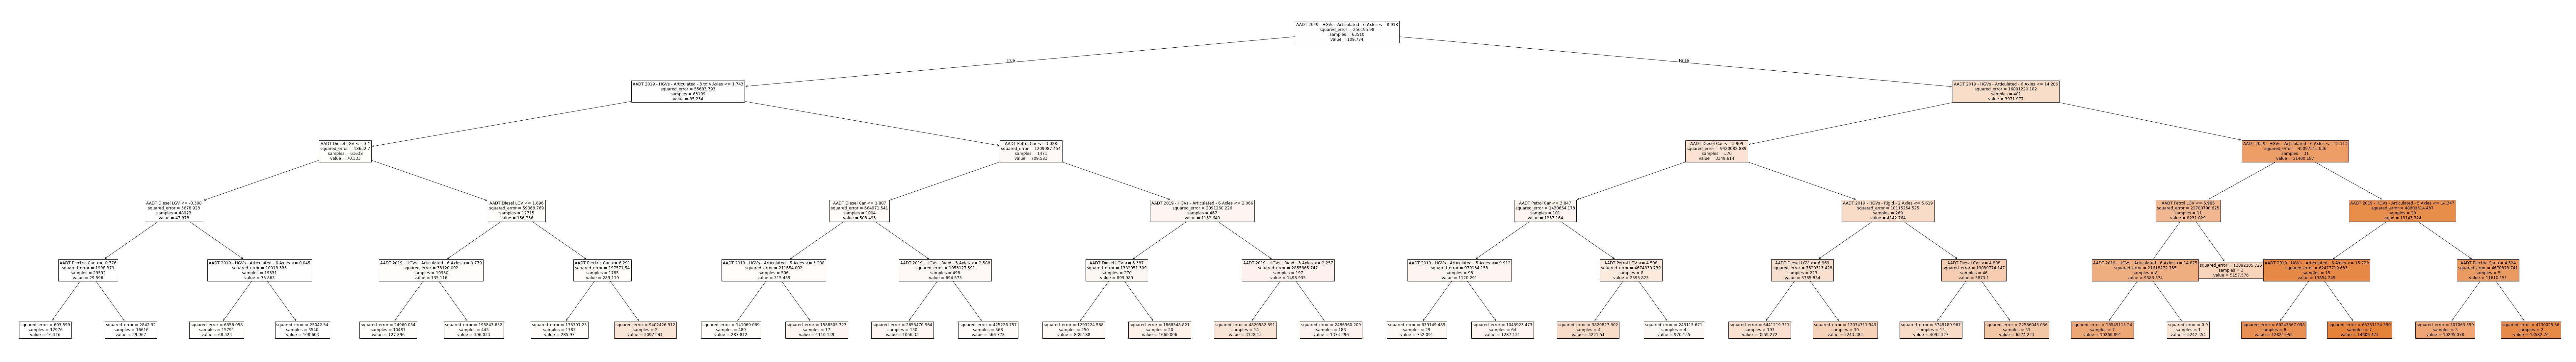

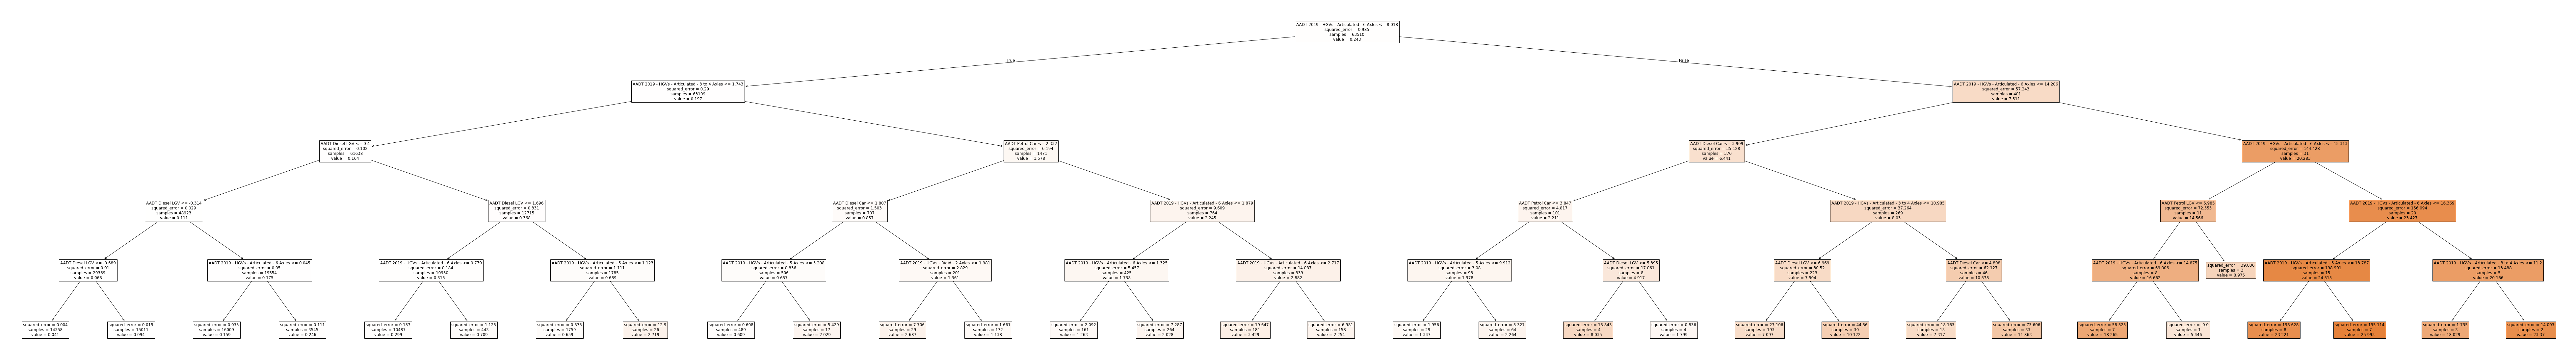

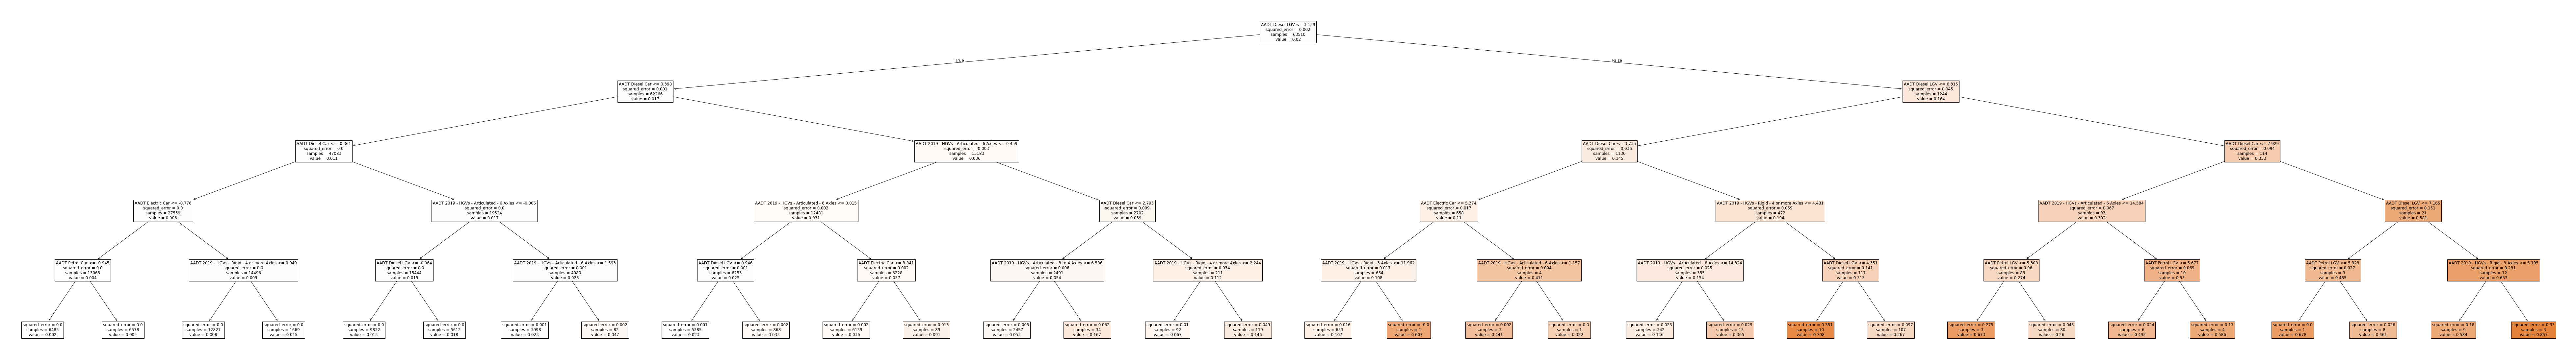

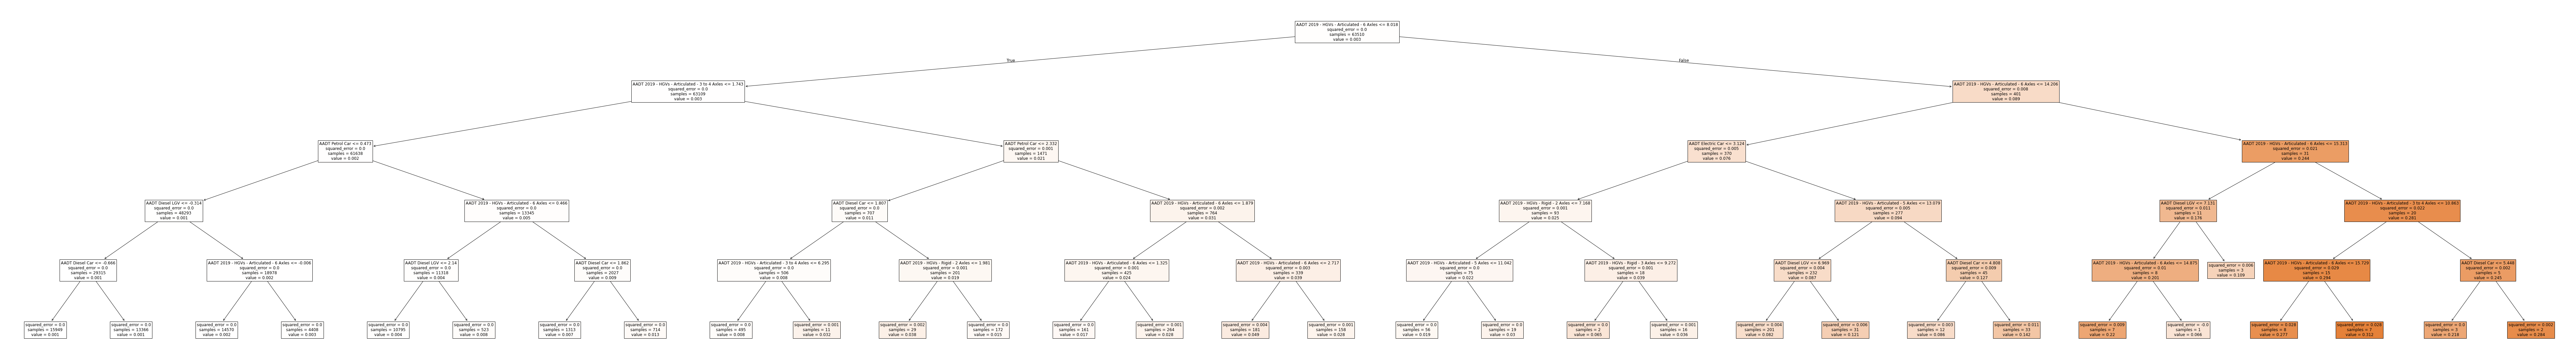

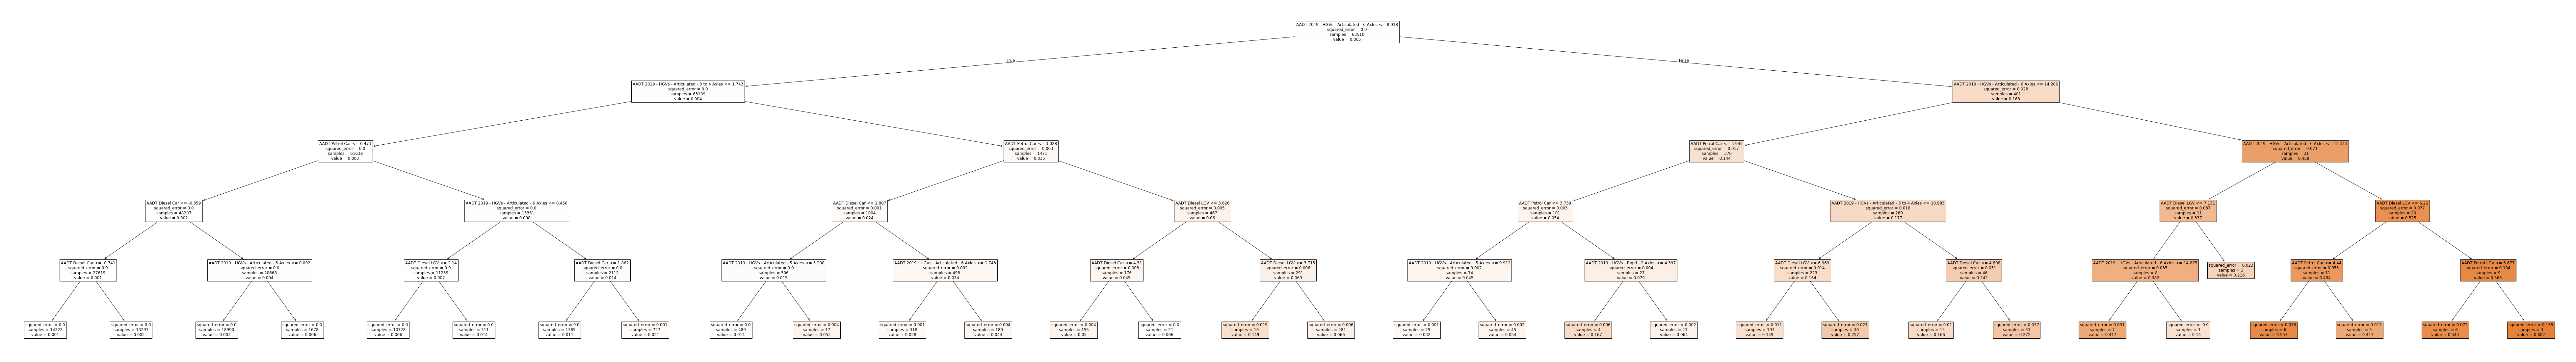

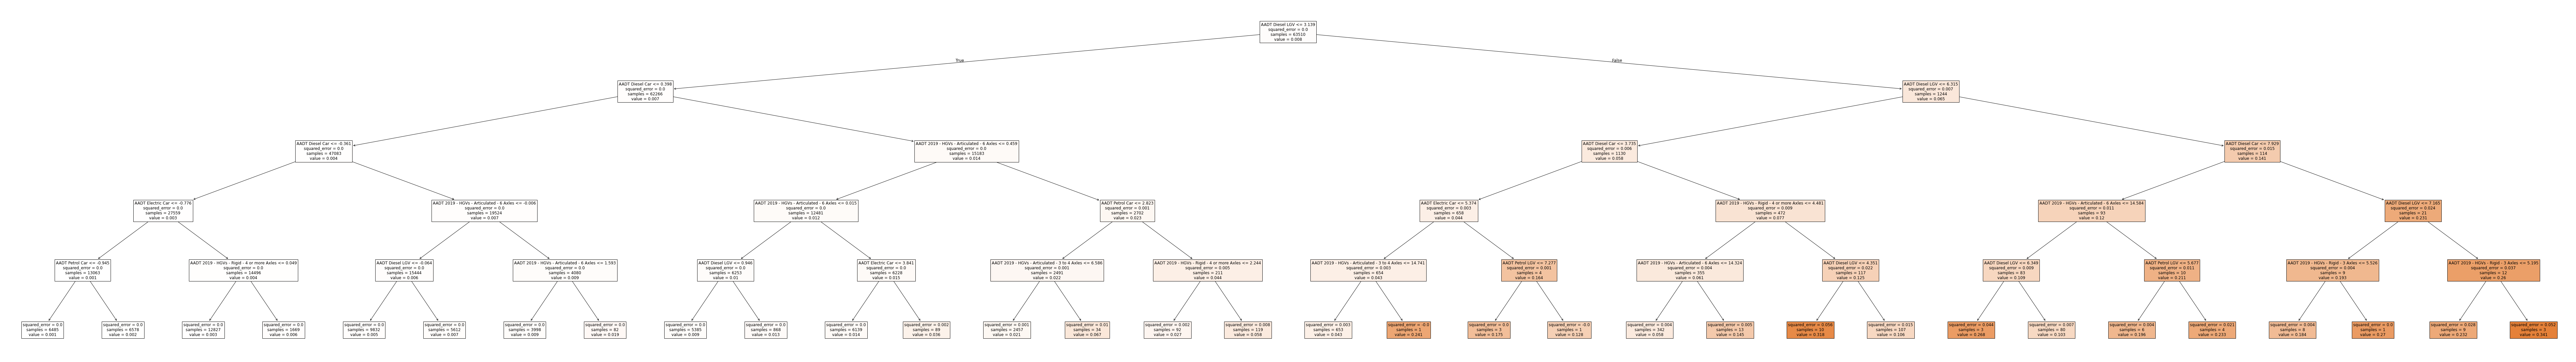

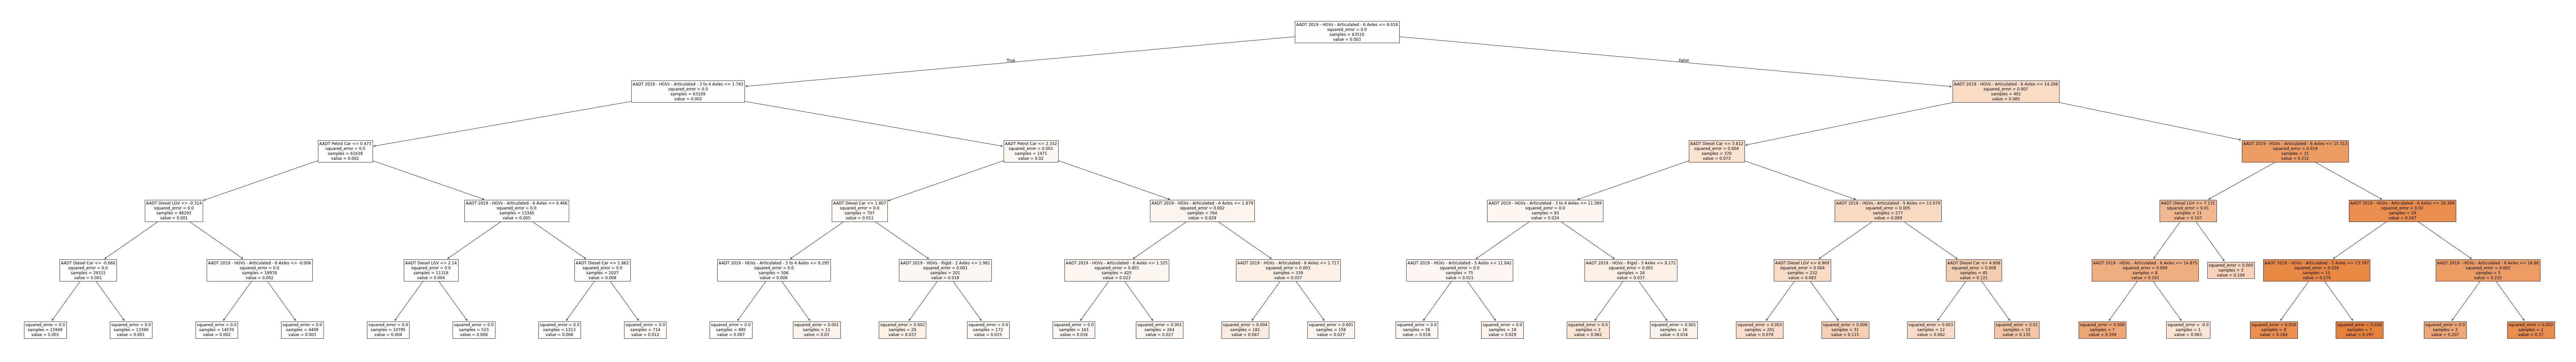

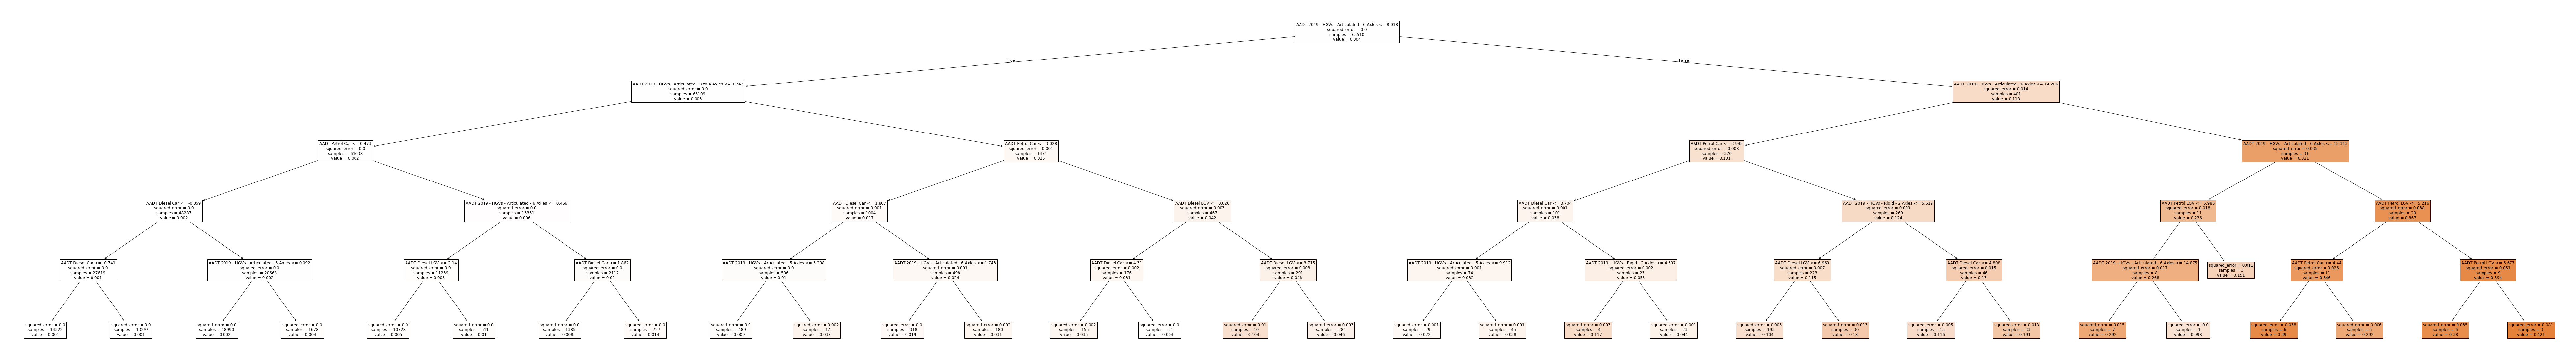

In [35]:
for k, v in DecisionTree_Results.items():
    fig, ax = pyplot.subplots(figsize=(140, 20))
    plot_tree(v['model'],
            ax=ax,
            feature_names=v['x_train'].columns,
            fontsize=12,
            filled=True)
    pyplot.savefig('charts/' + k + '_decision_tree.png')

# Results

- Export features to a CSV file
- Export results to a CSV file

In [23]:
# Folder to store the visuals
if not os.path.exists('results'):
    os.makedirs('results')

In [24]:
# Export the features to a CSV file
selected_features_df.to_csv('results/selected_features.csv', index=False)

In [37]:
# Export the experiment results to a CSV file
experimentresults_df = pandas.DataFrame(experimentresults_set, columns=['experiment', 'model', 'pollutant', 'mean_squared_error', 'root_mean_squared_error', 'r2_score', 'best_model', 'best_mean_squared_error', 'best_root_mean_squared_error', 'best_r2_score', 'best_params', 'best_score']) 
experimentresults_df.to_csv('results/consolidated_metrics.csv')                    